<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> 

Привет, Светлана! <br> Я постарался учесть и исправить твои замечания по проекту. Надеюсь все поправил верно<br></div>

<div class="alert alert-info">
Привет, Сергей! Меня зовут Светлана Чих и я буду проверять твой проект. Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе. Предлагаю общаться на «ты». Но если это не удобно - дай знать, и мы перейдем на «вы».

<div class="alert alert-success">
<b>👍 Успех:</b> Зелёным цветом отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах.
</div>
<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
</div>
<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Красным цветом выделены комментарии, без исправления которых, я не смогу принять проект :(
</div>
<div class="alert alert-info">
<b>👂 Совет:</b> Какие-то дополнительные материалы
</div>
Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Например, вот так.</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта быстрее.
 </div>

<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> В проекте должна быть описательная часть</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Добавил.</div>

## Постановка задачи

Для каршеринговой компании требуется создать систему предсказания виновника ДТП. 

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Задача — понять, возможно ли предсказывать виновность в ДТП, опираясь на исторические данные.

*Идея решения задачи:*

- Создать модель предсказания виновности ДТП (целевое значение — `at_fault` (виновник) в таблице `parties`, тип виновника - машина `car`.
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа `scratch` (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП.
- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
 - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
 - Какие ещё факторы нужно учесть?

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [1]:
# !pip install optuna
# !pip install skorch

In [2]:
import warnings

import random
from math import ceil

from sqlalchemy import create_engine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import optuna

from catboost import Pool, cv, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import torch 
import torch.nn as nn

from skorch import NeuralNetClassifier

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 40)
sns.set_theme(style='darkgrid')
RND_ST = 42
N_FOLDS = 5
TIME_FORMAT = '%H:%M:%S'
TST_SZE = .2

<div class="alert alert-success">
<b>👍 Успех:</b> Импортированы нужные библиотеки, настроен вывод, определны константы!
</div>

## Подключитесь к базе. Загрузите таблицы sql

In [4]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

In [5]:
engine = create_engine(connection_string)

In [6]:
def showsql(query, return_df=False):
    '''Функция выводит на экран или сохраняет в переменную результат sql запроса'''
    
    task = pd.read_sql_query(query, con=engine)
    if return_df:
        return task
    else:
        display(task)

<div class="alert alert-success">
<b>👍 Успех:</b> Создано подключение к БД!
</div>

## Проведите первичное исследование таблиц

In [7]:
query_0 = '''
WITH size_part AS(
SELECT table_name,
       pg_size_pretty(table_size) AS table_size,
       pg_size_pretty(indexes_size) AS indexes_size,
       pg_size_pretty(total_size) AS total_size
FROM (
      SELECT table_name,
             pg_table_size(quote_ident(table_name)) AS table_size,
             pg_indexes_size(quote_ident(table_name)) AS indexes_size,
             pg_total_relation_size(quote_ident(table_name)) AS total_size
      FROM (
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema IN ('public')
           ) AS t_name
      ) AS t_name_size
),

page_part AS (
SELECT relname,
       relpages,
       reltuples
FROM pg_class
WHERE relname IN ('collisions', 'parties', 'vehicles', 'case_ids')
),

columns_part AS(
SELECT table_name,
       COUNT(column_name) AS columns_qty
FROM information_schema.columns
WHERE table_schema = 'public'
GROUP BY table_name)

SELECT s.table_name,
       table_size,
       indexes_size,
       total_size,
       relpages AS pages_qty,
       reltuples AS rows_qty,
       columns_qty
FROM size_part AS s
JOIN page_part AS p ON s.table_name=p.relname
JOIN columns_part AS c ON c.table_name=s.table_name
'''
showsql(query_0)

,table_name,table_size,indexes_size,total_size,pages_qty,rows_qty,columns_qty
0,case_ids,59 MB,30 MB,89 MB,7568,1400000.0000,2
1,collisions,302 MB,0 bytes,302 MB,38644,1400000.0000,20
2,parties,246 MB,59 MB,305 MB,31467,2752408.0000,9
3,vehicles,63 MB,22 MB,85 MB,8029,1021234.0000,6


In [8]:
query_columns = '''
SELECT table_name,
       column_name,
       data_type 
FROM INFORMATION_SCHEMA.COLUMNS 
WHERE table_name = '''

In [9]:
for col in ("'collisions'", "'parties'", "'vehicles'", "'case_ids'"):
    query_res = query_columns + str(col)
    print('Таблица: ', col)
    showsql(query_res)

Таблица:  'collisions'


,table_name,column_name,data_type
0,collisions,party_count,integer
1,collisions,intersection,integer
2,collisions,distance,real
3,collisions,collision_date,date
4,collisions,collision_time,time without time zone
5,collisions,location_type,text
6,collisions,collision_damage,text
7,collisions,case_id,text
8,collisions,pcf_violation_category,text
9,collisions,type_of_collision,text


Таблица:  'parties'


,table_name,column_name,data_type
0,parties,cellphone_in_use,integer
1,parties,party_number,integer
2,parties,at_fault,integer
3,parties,insurance_premium,integer
4,parties,id,integer
5,parties,case_id,text
6,parties,party_drug_physical,text
7,parties,party_type,text
8,parties,party_sobriety,text


Таблица:  'vehicles'


,table_name,column_name,data_type
0,vehicles,id,integer
1,vehicles,party_number,integer
2,vehicles,vehicle_age,integer
3,vehicles,case_id,text
4,vehicles,vehicle_type,text
5,vehicles,vehicle_transmission,text


Таблица:  'case_ids'


,table_name,column_name,data_type
0,case_ids,case_id,text
1,case_ids,db_year,text


**Вывод:**
1. Все таблицы содержат данные
| Таблица | Размер, Мб | Строки | Столбцы |
| :- | :-: | :-: | :-: |
| collisions | 302  | 1 400 000 | 20 |
| parties | 246  | 2 752 410 | 9 |
| vehicles | 63  | 1 021 234 | 6 |
| case_ids | 59  | 1 400 000 | 2 |

2. Кол-во таблиц соответствует условию задачи
3. У всех таблиц есть общий ключ - поле `case_id`, тип данных `text`. Таблицы `parties` и `vehicles` дополнительно имеют поле `party_number`, тип данных `integer`, которое в связке с полем `case_id` позволяет объединить всех участников одного ДТП (уникального `case_id`)

<div class="alert alert-success">
<b>👍 Успех:</b> Проверено наличие всех таблиц и выведена инфрмация о них!
</div>

##  Проведите статистический анализ факторов ДТП

### В какие месяцы происходит наибольшее количество аварий.

Проанализируем весь период наблюдений.

In [10]:
query_collisions_by_month = '''
WITH tmp AS (
SELECT EXTRACT('month' FROM collision_date) AS n_month,
       COUNT(case_id) AS collisions_qty
FROM collisions
GROUP BY EXTRACT('month' FROM collision_date)
ORDER BY n_month ASC
)

SELECT to_char(to_timestamp(n_month::text, 'MM'), 'Month') AS month,
       collisions_qty
FROM tmp
'''
df_collisions_by_month = showsql(query_collisions_by_month, True)

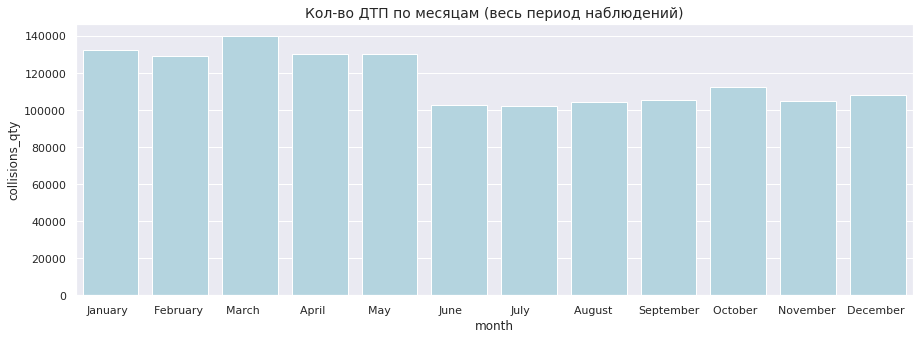

In [11]:
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='month',
            y='collisions_qty',
            data=df_collisions_by_month,
            color='lightblue')
ax.set_title('Кол-во ДТП по месяцам (весь период наблюдений)', fontsize=14)
plt.show()

**Вывод:**<br>
Максимальное кол-во ДТП регистрируется в зимние (кроме декабря) и весенние месяцы (вероятно, сказывается состояние дорог в этот период), минимальное - в летние месяцы, очень небольшой рост наблюдается в осенние месяцы (по сравнению с летом).

Кол-во ДТП и кол-во месяцев в статистике с разбивкой по годам:

In [12]:
query_collisions_monthsInside_by_year = '''
SELECT EXTRACT('Year' FROM collision_date) AS collision_year,
       COUNT(DISTINCT(EXTRACT('Month' FROM collision_date))) AS month_qty,
       COUNT(case_id) AS collisions_qty
FROM collisions
GROUP BY EXTRACT('Year' FROM collision_date)
ORDER by collision_year
'''
showsql(query_collisions_monthsInside_by_year)

,collision_year,month_qty,collisions_qty
0,2009.0000,12,426228
1,2010.0000,12,416490
2,2011.0000,12,402428
3,2012.0000,12,154547
4,2013.0000,6,305
5,2020.0000,2,2


**Вывод:**<br>
Данные неравномерны. С 2009 по 2012 данные присутствуют за 12 месяцев, за 2013 и 2020 годы данных крайне мало и только за 6 и 2 месяца соответственно. При этом кол-во зарегистрированных ДТП за 2009 - 2011 годы находится примерно на одной отметке (400+ тыс случаев), а в 2012 году кол-во зарегистрированных ДТП резко снижается в 2.6 раза.

Выведем графики кол-ва ДТП по месяцам с разбивкой по годам для периода 2009 - 2012:

In [13]:
query_collisions_by_month_yearSplit = '''
WITH tmp AS (
SELECT EXTRACT('year' FROM collision_date) AS year,
       EXTRACT('month' FROM collision_date) AS n_month,
       COUNT(case_id) AS collisions_qty
FROM collisions
WHERE EXTRACT('year' FROM collision_date) < 2013
GROUP BY EXTRACT('year' FROM collision_date), EXTRACT('month' FROM collision_date)
)

SELECT year::numeric::integer,
       to_char(to_timestamp(n_month::text, 'MM'), 'Month') AS month,
       collisions_qty
FROM tmp
'''
df_collisions_by_month_yearSplit = showsql(query_collisions_by_month_yearSplit, True)

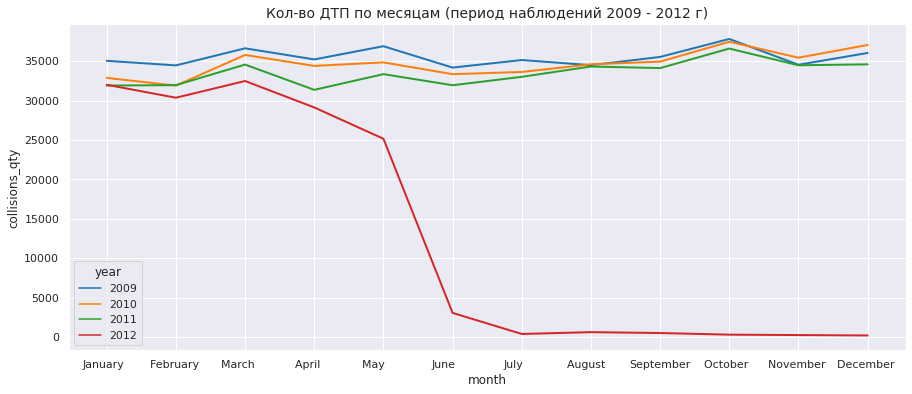

In [14]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='month',
             y='collisions_qty',
             hue='year',
             data=df_collisions_by_month_yearSplit,
             palette='tab10', linewidth=2)
ax.set_title('Кол-во ДТП по месяцам (период наблюдений 2009 - 2012 г)', fontsize=14)
plt.show()

**Вывод:**<br>
Очень сильное отличие в данных за 2012 год. До Апреля включительно картина очень напоминает данные за предыдущие года, но начиная с Мая и до Июня идет резкое снижение числа зарегистрированных ДТП и далее - стабилизация практически на околонулевой отметке.

Выведем данные за 2012 по кол-ву ДТП с разбивкой по месяцам в цифрах:

In [15]:
query_collisions_by_month_2012 = '''
WITH tmp AS (
SELECT EXTRACT('month' FROM collision_date) AS n_month,
       COUNT(case_id) AS collisions_qty
FROM collisions
WHERE EXTRACT('year' FROM collision_date) = 2012
GROUP BY EXTRACT('month' FROM collision_date)
ORDER BY n_month ASC
)

SELECT to_char(to_timestamp(n_month::text, 'MM'), 'Month') AS month_2012,
       collisions_qty
FROM tmp
'''
showsql(query_collisions_by_month_2012)

,month_2012,collisions_qty
0,January,32020
1,February,30377
2,March,32498
3,April,29143
4,May,25168
5,June,3062
6,July,390
7,August,622
8,September,510
9,October,304


<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Что в итоге с количеством аварий по месяцам? Какой окончательный вывод можно сделать с учетом всех проведеных иследований?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

**Вывод:**
Наибольшее кол-во аварий в 2012 году приходится на первый три месяца. Вероятно это связано с погодными условиями

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> В 2012 году это связано с неполными данными, а если смотреть только полные данные, то хорошо видно, что число аварий примерно одинаково во всех месяцах
</div>

### Аналитические задачи

**Задача 1**

Для каждого из населенных пунктов `COUNTY_LOCATION` исследовать данные `за 2012 год` на предмет зависимости между виновностью водителя в ДТП и признаком `DIRECTION`. 

**P.S.** Поскольку поле `DIRECTION` находится в таблице `collisions`, то оно означает скорее не направление движения кого-то из участников (иначе это поле было бы в таблице `parties`), а скорее-всего район населенного пункта.

In [16]:
# делаем RIGHT JOIN с таблицей vehicles чтоб в статистику попали только автомобили 
# не столбы, знаки и т.п.

query_fault_prob_by_place_by_direction = '''
WITH car_fault AS(
SELECT DISTINCT c.county_location,
       c.direction,
       COUNT(c.case_id) OVER(PARTITION BY c.county_location, c.direction) AS car_fault_qty
FROM collisions AS c
JOIN parties AS p ON c.case_id=p.case_id
RIGHT JOIN vehicles AS v ON (v.case_id=p.case_id AND v.party_number=p.party_number)
WHERE (EXTRACT('year' FROM c.collision_date) = 2012) AND (p.at_fault=1)
),

total AS(
SELECT DISTINCT county_location,
       direction,
       COUNT(case_id) OVER(PARTITION BY county_location) AS total_qty
FROM collisions
WHERE (EXTRACT('year' FROM collision_date) = 2012) AND (direction IS NOT NULL)
)

SELECT cf.county_location,
       cf.direction,
       cf.car_fault_qty,
       t.total_qty,
       (cf.car_fault_qty::real/t.total_qty::real*100) AS percent
FROM car_fault AS cf
JOIN total AS t ON (cf.county_location=t.county_location AND cf.direction=t.direction)
ORDER BY cf.county_location, cf.direction
'''
df_1 = showsql(query_fault_prob_by_place_by_direction, True)

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Использование INNER JOIN отфильтрует данные и останутся только те, которые есть во всех таблицах, в том числе и в vehicles. Мы не знаем есть ли данные по всем строкам из vehicles в других таблицах
</div>

In [17]:
df_1

,county_location,direction,car_fault_qty,total_qty,percent
0,alameda,east,322,4757,6.7690
1,alameda,north,328,4757,6.8951
2,alameda,south,304,4757,6.3906
3,alameda,west,310,4757,6.5167
4,alpine,east,7,28,25.0000
...,...,...,...,...,...
226,yolo,west,62,556,11.1511
227,yuba,east,19,207,9.1787
228,yuba,north,23,207,11.1111
229,yuba,south,21,207,10.1449


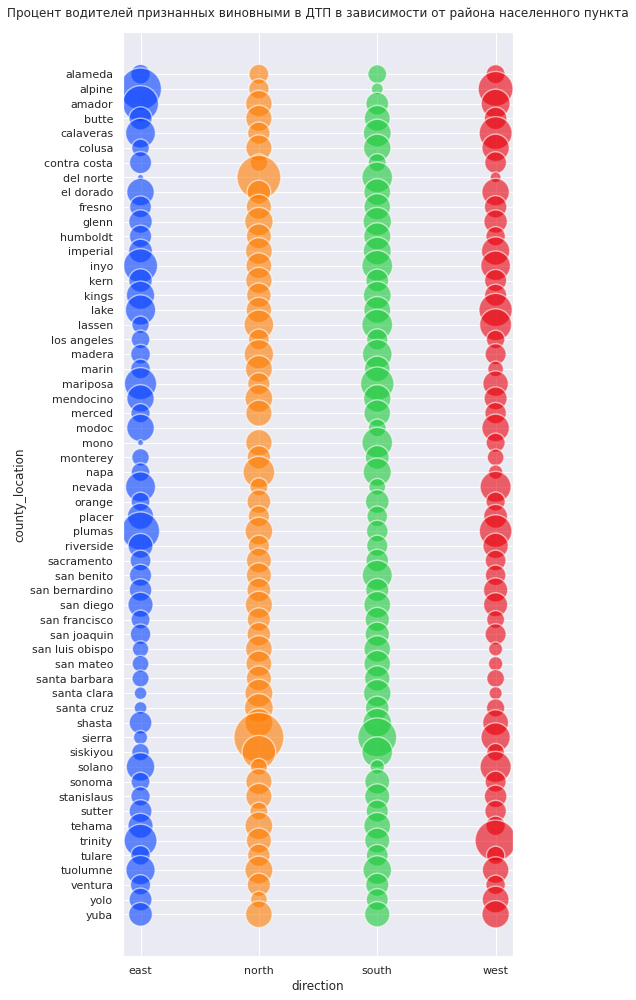

In [18]:
fig, ax = plt.subplots(figsize=(7, 17))
sns.scatterplot(data=df_1,
                x='direction',
                y='county_location',
                hue='direction',
                size='percent',
                sizes=(35, 2500),
                alpha=.6, 
                palette='bright',
                ax=ax,
                legend=False)
ax.tick_params(axis='x')
ax.set_title(
    'Процент водителей признанных виновными в ДТП в зависимости от района населенного пункта',
    fontsize=12,
    y=1.01)
plt.show()

**Вывод:**<br>
Для некоторых населенных пунктов (например: `alpine`, `del norte`, `mono`, `sierra`) довольно значительный процент признанных виновными в ДТП находились в определенном районе. И наоборот - есть районы, в которых в данном населенном пункте, водители очень редко признавались виновными в ДТП.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

**Задача 2**

Исследовать зависимость признания водителя виновным в ДТП от категории нарушения `PCF_VIOLATION_CATEGORY` и типа кузова `VEHICLE_TYPE`. Данные `за 2012 год`.

In [19]:
query_fault_by_violation_by_vtype = '''
WITH prep AS (
SELECT DISTINCT c.pcf_violation_category,
       v.vehicle_type,
       COUNT(c.case_id) OVER(PARTITION BY c.pcf_violation_category, v.vehicle_type) AS qty_per_vehicle_type,
       COUNT(c.case_id) OVER(PARTITION BY c.pcf_violation_category) AS qty_per_violation_type
FROM collisions AS c
JOIN parties AS p ON c.case_id=p.case_id
RIGHT JOIN vehicles AS v ON (v.case_id=p.case_id AND v.party_number=p.party_number)
WHERE EXTRACT('year' FROM c.collision_date) = 2012 AND (p.at_fault=1) AND (c.pcf_violation_category IS NOT NULL)
)

SELECT pcf_violation_category,
       vehicle_type,
       qty_per_vehicle_type,
       qty_per_violation_type,
       qty_per_vehicle_type::real/qty_per_violation_type::real*100 AS fault_percent
FROM prep
'''
df_2 = showsql(query_fault_by_violation_by_vtype, True)

In [20]:
df_2

,pcf_violation_category,vehicle_type,qty_per_vehicle_type,qty_per_violation_type,fault_percent
0,automobile right of way,coupe,3174,6815,46.5737
1,automobile right of way,hatchback,3,6815,0.0440
2,automobile right of way,minivan,428,6815,6.2803
3,automobile right of way,other,5,6815,0.0734
4,automobile right of way,sedan,3205,6815,47.0286
...,...,...,...,...,...
76,unsafe starting or backing,sedan,778,952,81.7227
77,wrong side of road,coupe,651,2047,31.8026
78,wrong side of road,hatchback,1,2047,0.0489
79,wrong side of road,minivan,1085,2047,53.0044


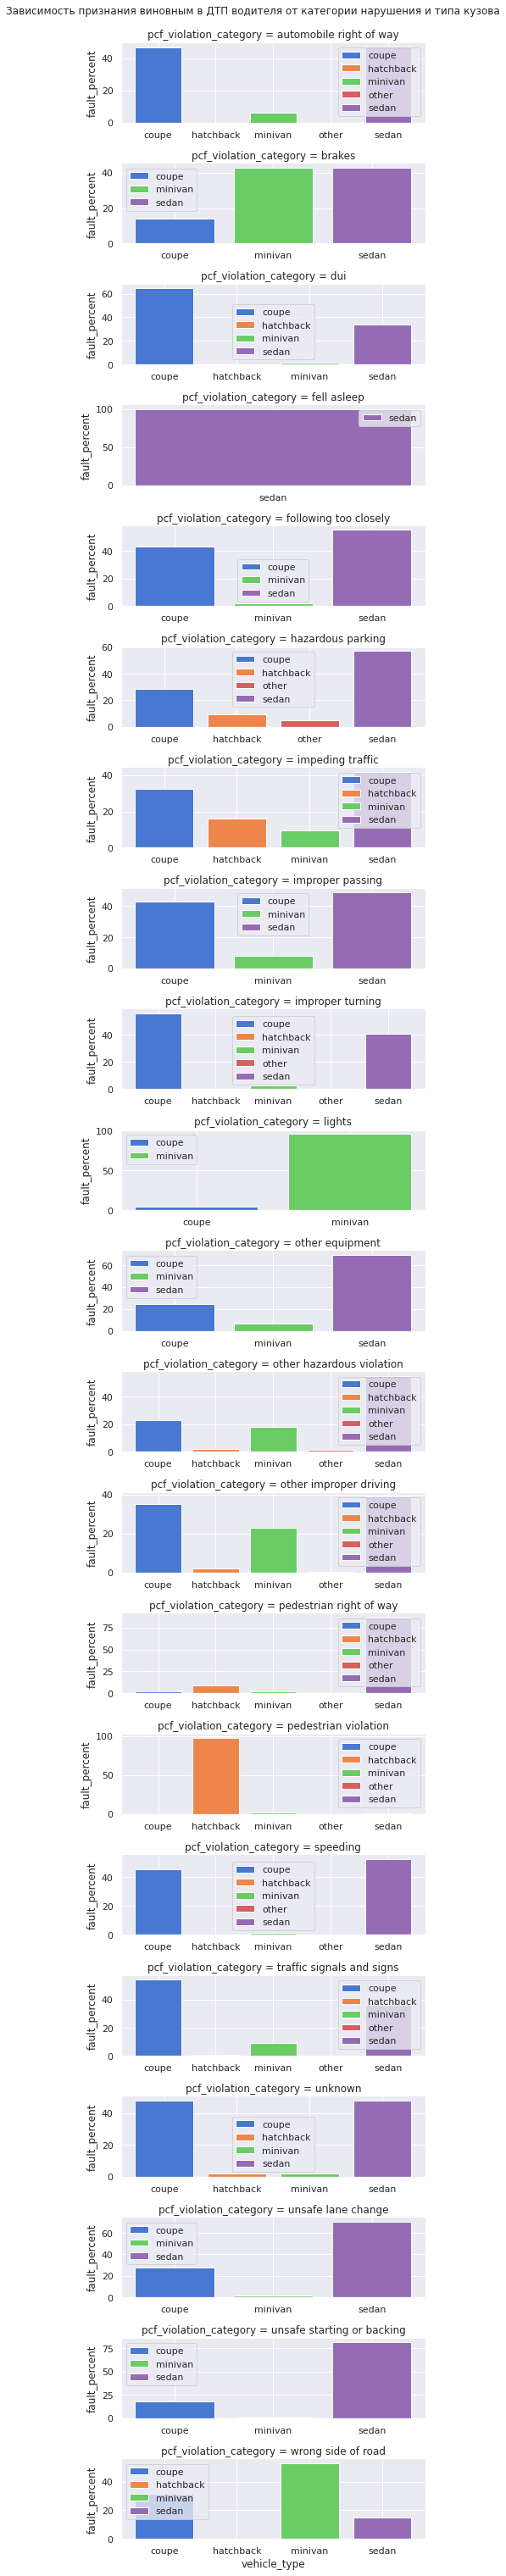

In [21]:
grid = sns.FacetGrid(df_2,
                     row='pcf_violation_category',
                     hue='vehicle_type',
                     sharex=False,
                     sharey=False,
                     palette='muted',
                     height=2,
                     aspect=3)

grid.map(plt.bar, 'vehicle_type', 'fault_percent', label='vehicle_type')
grid.fig.suptitle(
    'Зависимость признания виновным в ДТП водителя от категории нарушения и типа кузова',
    y = 1.005,
    fontsize = 12);

for ax in grid.axes[:, 0]:
    ax.legend()

**Вывод:**<br>
Из графиков можно сделать вывод что подавляющее большинство наршений ПДД совершили водители на автомобилях с типом кузова седан и купе

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Какая зависимость? У тебя построено столько графиков, значит по ним должен быть вывод. </s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Вывод должен содержать конкретную информацию, ты же провел исследование, что-то увидел, получил конкретные цифры, то есть у тебя есть точная информация - ее и нужно пиать в выводе, а не общие слова. Учитывай это во всех своих проектах
</div>

**Задача 3**

Исследовть частоту ДТП, произошедших по вине водителя, по типам ущерба `COLLISION_DAMAGE` в зависимости от погоды `WEATHER_1` и времени суток

In [22]:
query_damage_by_time_by_weather = '''
WITH tmp AS(
SELECT EXTRACT('hour' FROM c.collision_time)::integer AS hour_of_day,
       c.collision_damage,
       c.weather_1,
       c.case_id
FROM collisions AS c
JOIN parties AS p ON c.case_id=p.case_id
RIGHT JOIN vehicles AS v ON (v.case_id=p.case_id AND v.party_number=p.party_number)
WHERE (c.collision_damage NOT IN ('scratch'))
  AND (EXTRACT('year' FROM c.collision_date) = 2012)
  AND (p.at_fault=1)
),

prepared AS (
SELECT DISTINCT hour_of_day,
       weather_1 AS weather,
       collision_damage,
       COUNT(case_id) OVER(PARTITION BY hour_of_day, weather_1, collision_damage) AS damage_type_qty,
       COUNT(case_id) OVER(PARTITION BY hour_of_day) AS total_qty
FROM tmp
WHERE (weather_1 IS NOT NULL) AND (hour_of_day IS NOT NULL)
ORDER BY hour_of_day, weather, collision_damage ASC
)

SELECT hour_of_day,
       weather,
       collision_damage,
       damage_type_qty,
       total_qty,
       (damage_type_qty::real/total_qty::real*100) AS percent
FROM prepared
'''
df_3 = showsql(query_damage_by_time_by_weather, True)

In [23]:
df_3

,hour_of_day,weather,collision_damage,damage_type_qty,total_qty,percent
0,0,clear,fatal,77,748,10.2941
1,0,clear,middle damage,263,748,35.1604
2,0,clear,severe damage,65,748,8.6898
3,0,clear,small damage,194,748,25.9358
4,0,cloudy,fatal,15,748,2.0053
...,...,...,...,...,...,...
398,23,raining,middle damage,20,917,2.1810
399,23,raining,severe damage,5,917,0.5453
400,23,raining,small damage,22,917,2.3991
401,23,snowing,middle damage,1,917,0.1091


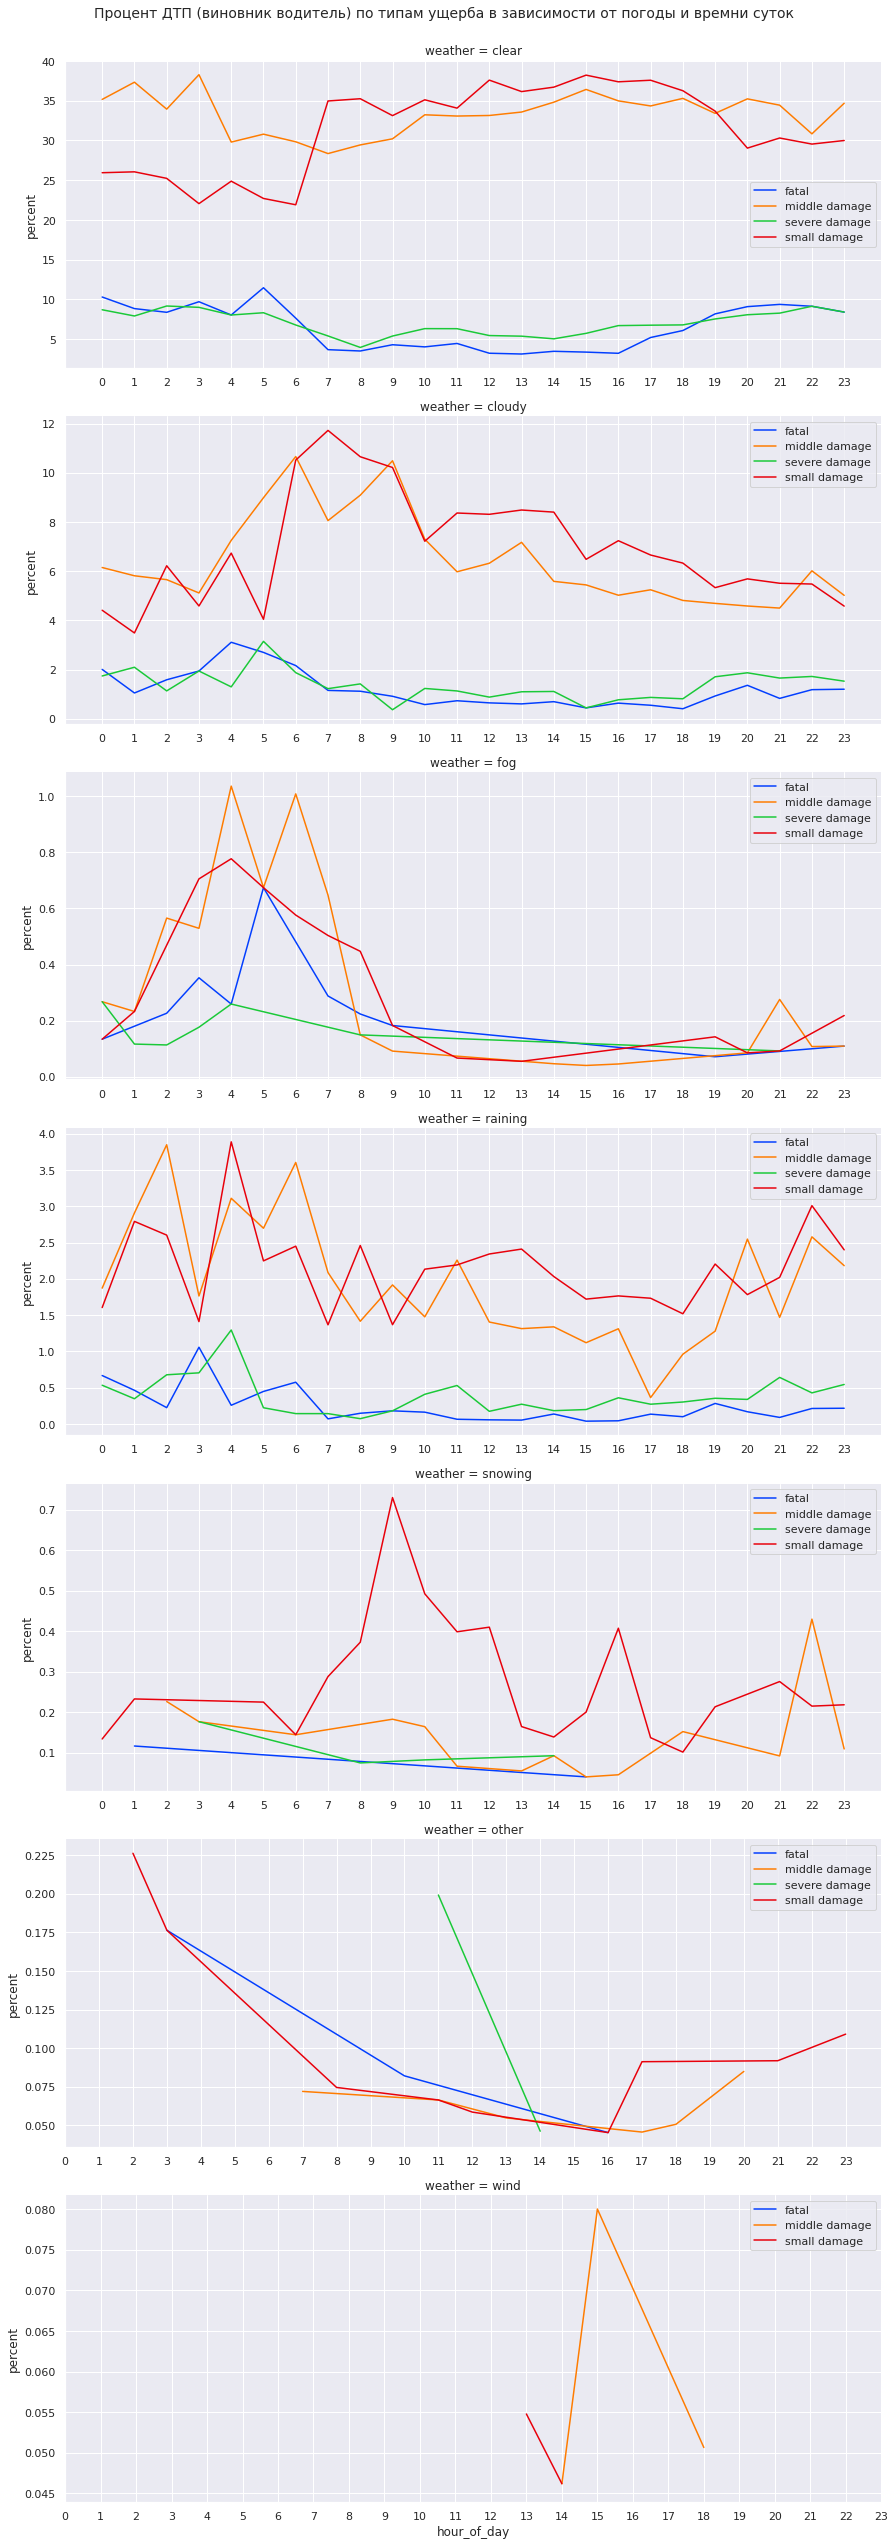

In [24]:
grid = sns.FacetGrid(df_3,
                     row='weather',
                     hue='collision_damage',
                     sharex=False,
                     sharey=False,
                     palette='bright',
                     height=5,
                     aspect=2.5)

grid.map(plt.plot,
         'hour_of_day',
         'percent',
         label='collision_damage')
grid.fig.suptitle(
    'Процент ДТП (виновник водитель) по типам ущерба в зависимости от погоды и времни суток',
    y = 1.01,
    fontsize = 14);

for ax in grid.axes[:, 0]:
    ax.legend()
    ax.set_xticks(range(0, 24, 1))

**Вывод:**<br>
* Наибольшее кол-во аварий происходит в ясную погоду. Вероятно это связано с кол-вом машин на дорогах. Как правило в ясную погоду машин на дорогах больше.
* При плохих погодных условиях кол-во аварий возрастает в ночные и утрение часы.

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> В выводах должно быть опиано что конкретно видно по графикам, а не то, что там можно отселдить. Какие периоды? Когда чило ДТП растет, а когда снижается?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Отличные выводы (можно писать их более развернутыми)
</div>

**Задача 4**

Выявить наличие несогласованности данных в таблицах `parties` и `vehicles`

На этапе выполнения предыдущих задач выявлен факт того, что не согласуется тип участника `party_type` в таблицах `parties` и `vehicles` в связке с полем порядкового номера участника `party_number`. Таким образом при выборе в таблице `parties` условия `party_type='car'` мы на самом деле выкидываем почти 97 тыс.!!! участников, которые **являются** автомобилями. Запрос ниже выводит несоответствия между данными в таблицах `parties` и  `vehicles` в поле `party_type` , соответствующие данному ДТП `case_id` и порядковому номеру участника `party_number` 

In [25]:
query_parties_vehicles_bugs = '''
SELECT p.case_id::integer AS p_case_id,
       v.case_id::integer AS v_case_id,
       p.party_number::integer AS p_party_number,
       v.party_number::integer AS v_party_number,
       p.party_type AS p_party_type,
       v.vehicle_type   
FROM parties AS p
RIGHT JOIN vehicles AS v ON (p.case_id=v.case_id AND p.party_number=v.party_number)
WHERE p.party_type NOT IN ('car')
'''
df_pv_bugs = showsql(query_parties_vehicles_bugs, True)

In [26]:
df_pv_bugs

,p_case_id,v_case_id,p_party_number,v_party_number,p_party_type,vehicle_type
0,4037437,4037437,2,2,road bumper,sedan
1,4001818,4001818,1,1,road signs,hatchback
2,4007680,4007680,2,2,road signs,hatchback
3,4012051,4012051,1,1,road signs,hatchback
4,4014983,4014983,3,3,road signs,hatchback
...,...,...,...,...,...,...
96787,5082744,5082744,2,2,building,minivan
96788,5082774,5082774,2,2,road signs,hatchback
96789,5083272,5083272,1,1,building,minivan
96790,5083332,5083332,2,2,road signs,hatchback


Поле `party_type` из таблицы `parties` нельзя использовать для фильтрации типа участника "автомобиль". Для этого необходимо синхронизироваться с таблицей `vehicles`, в которой содержатся только данные по автомобилям.

<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Судя по всему в таблицу vehicles были внсены данные не только по автомобилям, ошибки в данных частое явление. От заказчика у нас есть четкое условие party_type='car'
</div>

## Создайте модель для оценки водительского риска

### Загрузка и ознакомление с данными

Выбираем:
- тип виновника только машина (делаем `RIGHT JOIN` с таблицей `vehicles`).
- все типы повреждений, кроме `SCRATCH` (царапина).
- данные за `2012` год.
- подготовка исходной таблицы проводится с помощью sql-запроса.
- В задании от заказчика есть **обязательное условие** — учесть `фактор возраста` автомобиля `vehicle_age`. Записи, в которых есть пропуски в этом столбце придется исключить.

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Правое объединение здесь не нужно и обязательно нужно использовать party_type='car'. Нужно обосновать какие признаки и почему будут использоваться при построении и обучении модели, в запросе должны быть только те признаки, которые будут нужны</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

In [27]:
query_df_for_model = '''
SELECT c.case_id::integer,
       c.party_count::integer,
       p.party_number::integer AS p_party_number,
       v.party_number::integer AS v_party_number,
       p.party_type,
       v.vehicle_type,
       p.at_fault,
       v.vehicle_transmission,
       v.vehicle_age,
       c.county_city_location,
       c.county_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.collision_damage,
       c.primary_collision_factor,
       c.pcf_violation_category,
       c.type_of_collision,
       c.motor_vehicle_involved_with,
       c.road_surface,
       c.road_condition_1,
       c.lighting,
       c.control_device,
       to_char(c.collision_date, 'day') AS day_of_week,
       c.collision_date,
       EXTRACT(hour FROM c.collision_time) AS hour,
       c.collision_time,
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use
FROM collisions AS c
JOIN parties AS p ON c.case_id=p.case_id
RIGHT JOIN vehicles AS v ON (c.case_id=v.case_id AND p.party_number=v.party_number)
WHERE (EXTRACT('year' FROM c.collision_date) = 2012)
  AND (c.collision_damage NOT IN ('scratch'))
  AND (v.vehicle_age IS NOT NULL)
  AND party_type='car'
'''
df_raw = showsql(query_df_for_model, True)

In [28]:
df_raw = df_raw.sort_values(by=['collision_date',
                                'collision_time',
                                'vehicle_type',
                                'vehicle_age']).reset_index(drop=True)

In [29]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54554 entries, 0 to 54553
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      54554 non-null  int64  
 1   party_count                  54554 non-null  int64  
 2   p_party_number               54554 non-null  int64  
 3   v_party_number               54554 non-null  int64  
 4   party_type                   54554 non-null  object 
 5   vehicle_type                 54554 non-null  object 
 6   at_fault                     54554 non-null  int64  
 7   vehicle_transmission         53979 non-null  object 
 8   vehicle_age                  54554 non-null  int64  
 9   county_city_location         54554 non-null  object 
 10  county_location              54554 non-null  object 
 11  distance                     54554 non-null  float64
 12  direction                    42097 non-null  object 
 13  intersection    

In [30]:
df_raw.head()

,case_id,party_count,p_party_number,v_party_number,party_type,vehicle_type,at_fault,vehicle_transmission,vehicle_age,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,day_of_week,collision_date,hour,collision_time,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,5545774,2,2,2,car,sedan,0,auto,9,3610,san bernardino,200.0000,south,0.0000,clear,highway,small damage,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,sunday,2012-01-01,0.0000,00:07:00,46.0000,had not been drinking,None,0.0000
1,5455407,1,1,1,car,sedan,1,manual,8,1000,fresno,5280.0000,west,0.0000,clear,None,small damage,vehicle code violation,dui,overturned,non-collision,dry,normal,dark with no street lights,none,sunday,2012-01-01,0.0000,00:10:00,60.0000,"had been drinking, under influence",None,0.0000
2,5455320,1,1,1,car,coupe,0,auto,6,1950,los angeles,0.0000,None,1.0000,clear,None,middle damage,other than driver,other than driver (or pedestrian),hit object,fixed object,dry,normal,dark with street lights,none,sunday,2012-01-01,0.0000,00:17:00,38.0000,had not been drinking,None,0.0000
3,5467716,1,1,1,car,coupe,1,manual,3,5607,ventura,651.0000,north,0.0000,clear,None,middle damage,vehicle code violation,dui,hit object,fixed object,dry,normal,dark with street lights,none,sunday,2012-01-01,0.0000,00:18:00,19.0000,"had been drinking, under influence",None,0.0000
4,5455458,2,2,2,car,sedan,0,auto,2,1985,los angeles,80.0000,south,0.0000,clear,None,middle damage,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,sunday,2012-01-01,0.0000,00:23:00,36.0000,had not been drinking,None,0.0000


<div class="alert alert-success">
<b>👍 Успех:</b> Отлично, получился нужный датасет!
</div>

**Пропуски**

In [31]:
print(df_raw.isna().sum())
print('\nОбщее кол-во пропусков:', df_raw.isna().sum().sum())

case_id                            0
party_count                        0
p_party_number                     0
v_party_number                     0
party_type                         0
vehicle_type                       0
at_fault                           0
vehicle_transmission             575
vehicle_age                        0
county_city_location               0
county_location                    0
distance                           0
direction                      12457
intersection                     168
weather_1                        165
location_type                  29043
collision_damage                   0
primary_collision_factor          97
pcf_violation_category           721
type_of_collision                290
motor_vehicle_involved_with      147
road_surface                     329
road_condition_1                 237
lighting                         152
control_device                   206
day_of_week                        0
collision_date                     0
h

In [32]:
# Приведем строки к нижнему регистру
for item in df_raw.columns:
    try:
        df_raw[item] = df_raw[item].str.lower()
    except:
        pass

**Дубликаты**

In [33]:
df_raw.duplicated().sum()

0

**Баланс классов**

In [34]:
(
    df_raw['at_fault'].value_counts().to_frame()
    .assign(percent = lambda x: round(x / x['at_fault'].sum()*100, 1) )
)

,at_fault,percent
1,27541,50.5000
0,27013,49.5000


**Вывод:**<br>
Данные загружены с использованием SQL запроса, сохранены в переменную `df_raw`.

- Датасет содержит **54554** строки, **33** столбца. 
- Типы данных `float64(5)`, `int64(6)`, `object(22)`.
- В данных есть пропуски, общее кол-во пропусков **102 048**.
- Проверены дубликаты (отсутствуют)
- Проверен балланс классов (`0` / `1` - 49.5% / 50.5%).

### Первичный отбор факторов, необходимых для модели

Логика бизнесс задачи требует отбирать только факторы, которые известны непосредственно сразу после ДТП. Признаки, которые могут быть известны уже после проведения тщательного расследования, лучше отклонить.

- <font color='red'>**case_id**</font> это синтетический номер, присвоенный ДТП. Информацию он не содержит (можно, например, нумеровать буквами/символами, например A, AA, AA+ и т.п.). **отклоняем**.
- <font color='red'>**county_city_location**</font> является синонимом признака `county_location`. Для модели лучше использовать категориальные данные, чтоб численное значение не было интерпретировано как больший вес признака. **отклоняем**.
- <font color='lightgreen'>**county_location**</font> признак указывает на географическую точку ДТП.
- <font color='orange'>**distance**</font> признак указывает на расстояние от точки ДТП до главной дороги. Тоже некая географическая характеристика. Нужно смотреть подробнее.
- <font color='red'>**direction**</font>. содержит `14640` пропусков. Невозможно восстановить даже частично, используя данные от других участников одного и того же ДТП. Если оставлять признак, то придется удалять значительное число записей. **отклоняем** 
- <font color='red'>**intersection**</font> Имеет дублирование в виде значения признака `location_type='intersection'`.

In [35]:
# подсчет невосстановимых значений в direction
direction_nan_df = df_raw.groupby('case_id').agg(direction_count=('direction', 'count'))
direction_nan_case_id = direction_nan_df[direction_nan_df["direction_count"]==0].index
print('Число невосстановимых значений в direction',
      df_raw.query('case_id in @direction_nan_case_id').shape[0]
     )

Число невосстановимых значений в direction 12457


In [36]:
# пример, иллюстрирующий связь значений признаков 'intersection' и 'location_type'
df_raw[(df_raw['intersection'] == 1) 
       & (df_raw['location_type'] == 'intersection')][['intersection', 'location_type']][:5]

,intersection,location_type
199,1.0000,intersection
200,1.0000,intersection
217,1.0000,intersection
347,1.0000,intersection
348,1.0000,intersection


- <font color='lightgreen'>**weather_1**</font> признак указывает на погодные условия. Пропусков немного - всего `195`. Восстановить, опираясь на значения для других участников в рамках одного и того же `case_id` даже частично нельзя.

In [37]:
# подсчет невосстановимых значений в weather_1
weather_nan_df = df_raw.groupby('case_id').agg(weather_count=('weather_1', 'count'))
weather_nan_case_id = weather_nan_df[weather_nan_df["weather_count"]==0].index
print('Число невосстановимых значений в weather_1: ',
       df_raw.query('case_id in @weather_nan_case_id').shape[0],
     )
print('Доля невосстановимых значений в weather_1: ',
       df_raw.query('case_id in @weather_nan_case_id').shape[0] / df_raw.shape[0],
     )

Число невосстановимых значений в weather_1:  165
Доля невосстановимых значений в weather_1:  0.0030245261575686474


<div class="alert alert-danger">
    <s><b>😔 Необходимо исправить:</b> Какой это процент от датасета?</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

- <font color='red'>**location_type**</font> содержит `35016` пропусков. Невозможно восстанвоить даже частично, используя данные от других участников одного и того же `case_id`. Если оставлять признак, то придется удалять значительное число записей. **отклоняем**

In [38]:
# подсчет невосстановимых значений в location_type
location_type_nan_df = df_raw.groupby('case_id').agg(location_type_count=('location_type', 'count'))
location_type_nan_case_id = location_type_nan_df[location_type_nan_df["location_type_count"]==0].index
print('Число невосстановимых значений в location_type: ',
       df_raw.query('case_id in @location_type_nan_case_id').shape[0]
     )

print('Доля невосстановимых значений в location_type: ',
       df_raw.query('case_id in @location_type_nan_case_id').shape[0] / df_raw.shape[0],
     )

Число невосстановимых значений в location_type:  29043
Доля невосстановимых значений в location_type:  0.532371595116765


- <font color='red'>**collision_damage**</font> предполагаю, что эти данные известны уже **ПОСЛЕ** установления виновника ДТП. **отклоняем**. 
- <font color='red'>**party_count**</font> число участников будет одинаково для всех участников ДТП, в том числе и для виновника. Однако, признак может корректировать вероятность по формуле 1/N для каждого участника. Пока оставляем, необходимо дополнительное исследование.**отклоняем**
- <font color='red'>**pcf_violation_category**</font> предполагаю, что эти данные известны уже **ПОСЛЕ** установления виновника ДТП. **отклоняем**. 
- <font color='red'>**primary_collision_factor**</font> предполагаю, что эти данные известны уже **ПОСЛЕ** установления виновника ДТП. **отклоняем**.
- <font color='red'>**type_of_collision**</font> тип повреждения может однозначно указать на виновника ДТП. Например, если столкновение произошло с неподвижным объектом `hit object`, то ... очень вероятно виновен водитель.**отклоняем**
- <font color='red'>**motor_vehicle_involved_with**</font> этот признак точно нужен, так как характеризует объект, с которым столкнулся автомобиль. Предположим, это велосипедист `bicycle `... вероятность стать виновником ДТП увеличивается. **отклоняем**
- <font color='orange'>**road_surface**</font> признак состояния поверхности. Требует более подробного изучения.
- <font color='orange'>**road_condition_1**</font> признак дорожных условий. Требует дальнейшего изучения.
- <font color='orange'>**lighting**</font> признак освещенности. Требует дальнейшего изучения.
- <font color='red'>**control_device**</font> не очень ясно, что означает этот признак. К тому же очень много значений `none`. **отклоняем**

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> party_count будет изветно только после ДТП, объект с которым столкнется автомобиль тоде невозможно предсказать до начала поездки, тип повреждения тоже не может быть известен. Учитывая, что нащ клиент каршеринговая компания, стоит ограничить возраст автомобилей 10-ю годами. Пропуски можно заполнять заглушками. Обучение и выбор лучшей модели должны быть прочедены с помощью кроссвалидации, на тестовых данных нужно протестировать только одну лучшую модель. Сейчас у тебя используются признаки, которые не могут быть известны до начала поездки.</s>
</div>

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Исправил.</div>

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [39]:
df_raw['control_device'].value_counts()

none               36679
functioning        17528
not functioning      112
obscured              29
Name: control_device, dtype: int64

- <font color='red'>**collision_date**</font> вместо даты выберем признак `day_of_week`
- <font color='orange'>**day_of_week**</font> треубет дополнительного изучения
- <font color='red'>**collision_time**</font>  вместо времени выберем признак `hour`
- <font color='orange'>**hour**</font> требует дополнительного изучения.
- <font color='orange'>**insurance_premium**</font> признак может влиять на стиль езды водителя и соответственно на его склонность к нарушению правил движения.
- <font color='lightgreen'>**party_sobriety**</font> признак должен сильно влиять на риск признания виновником ДТП.
- <font color='red'>**party_drug_physical**</font> значительно влияет на виновность в ДТП. Однако, очень много пропусков и незаполненных значений. **отклоняем**.
- <font color='orange'>**cellphone_in_use**</font> в описании к признаку указано, что он означает наличие громкой связи в автомобиле. Пока не понятно как это влияет на вероятность признания виновником ДТП. Требуется дальнейшая оценка.
- <font color='red'>**party_type**</font> выбраны только автомобили т.к. мы синхронизировались с таблицей `vehicles` **отклоняем**.
- <font color='orange'>**vehicle_type**</font> признак может влиять на стиль езды водителя и соответственно на его склонность к нарушению правил движения.
- <font color='orange'>**vehicle_transmission**</font> признак может влиять на стиль езды водителя и соответственно на его склонность к нарушению правил движения.
- <font color='lightgreen'>**vehicle_age**</font> нужен по условию

**Вывод:**

Точно нужны 6 признаков:
- <font color='lightgreen'>**county_location**</font>
- <font color='lightgreen'>**weather_1**</font>
<!-- - <font color='lightgreen'>**type_of_collision**</font> -->
<!-- - <font color='lightgreen'>**motor_vehicle_involved_with**</font> -->
- <font color='lightgreen'>**party_sobriety**</font>
- <font color='lightgreen'>**vehicle_age**</font>

Еще 11 признаков требуют дополнительного анализа или трансформации:
- <font color='orange'>**distance**</font>
<!-- - <font color='orange'>**party_count**</font> -->
- <font color='orange'>**road_surface**</font>
- <font color='orange'>**road_condition_1**</font>
- <font color='orange'>**lighting**</font>
- <font color='orange'>**day_of_week**</font>
- <font color='orange'>**hour**</font>
- <font color='orange'>**insurance_premium**</font>
- <font color='orange'>**cellphone_in_use**</font>
- <font color='orange'>**vehicle_type**</font>
- <font color='orange'>**vehicle_transmission**</font>

In [40]:
df_raw = df_raw.rename(columns={'weather_1':'weather',
                                'road_condition_1':'road_condition'})

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

### Исследование отобранных факторов

#### Признаки, требующие дополнительного анализа.

In [41]:
def cross_prob_bar(col_to_cross_name, ax):
    
    """
    строит нормализованную диаграмму соотношения значений целевого признака для значений выбранного признака
    """
    
    (pd.crosstab(df_raw[col_to_cross_name], df_raw['at_fault'], margins=True)
    .drop('All', axis=0)
    .assign(norm_0 = lambda x: x[0]/x['All'])
    .assign(norm_1 = lambda x: x[1]/x['All'])[['norm_0', 'norm_1']]
    .rename(columns={'norm_0':'0', 'norm_1':'1'})
    .plot(kind='bar', ax=ax, stacked=True, color=['lightgreen', 'brown'], alpha=.75))

In [42]:
def cross_prob_bar_prob_order(col_to_cross_name, ax):
    
    """
    строит нормализованную диаграмму соотношения значений целевого признака для значений выбранного признака
    диаграмма упорядочена по соотношениею значений целевого признака
    """
    
    (pd.crosstab(df_raw[col_to_cross_name], df_raw['at_fault'], margins=True)
    .drop('All', axis=0)
    .assign(norm_0 = lambda x: x[0]/x['All'])
    .assign(norm_1 = lambda x: x[1]/x['All'])[['norm_0', 'norm_1']]
    .rename(columns={'norm_0':'0', 'norm_1':'1'})
    .sort_values(by='0')
    .plot(kind='bar', ax=ax, stacked=True, color=['lightgreen', 'brown'], alpha=.75))

**`distance`**

In [43]:
df_raw[['distance']].describe()

,distance
count,54554.0000
mean,876.1480
std,7348.6992
min,0.0000
25%,9.0000
50%,143.0000
75%,575.7500
max,1584000.0000


Есть выбросы сверху. Посмотрим на распределение ниже `.99` квантиля

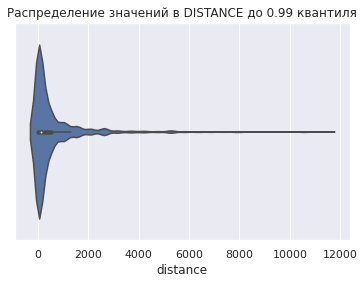

In [44]:
sns.violinplot(df_raw[df_raw['distance'] < df_raw['distance'].quantile(.99)]['distance'])
plt.title('Распределение значений в DISTANCE до 0.99 квантиля');

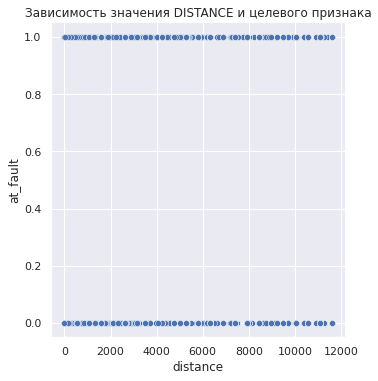

In [45]:
sns.relplot(
    data=df_raw[df_raw['distance'] <= df_raw['distance'].quantile(.99)],
    x='distance', y='at_fault'
)
plt.title('Зависимость значения DISTANCE и целевого признака');

**Вывод:** слабый признак. <font color='red'>**отклоняем**</font>

**`party_count`**

In [46]:
df_raw['party_count'].value_counts()

2     34424
1      9988
3      7363
4      1981
5       575
6       142
7        42
8        19
9        17
10        3
Name: party_count, dtype: int64

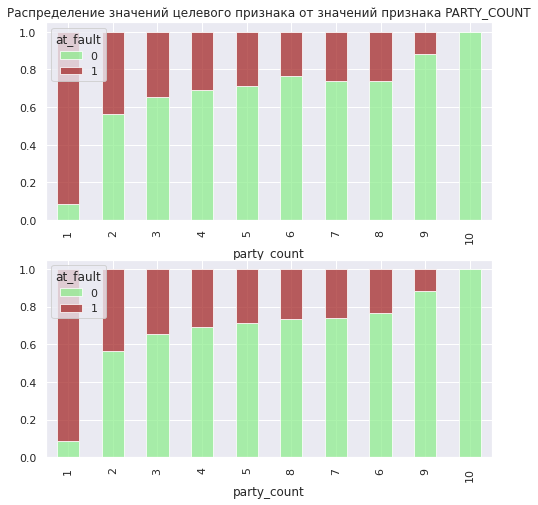

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
cross_prob_bar('party_count', ax[0])
cross_prob_bar_prob_order('party_count', ax[1])
ax[0].set_title(
    'Распределение значений целевого признака от значений признака PARTY_COUNT',
    fontsize=12
)
plt.show()

**Вывод:** Признак вносит поправку в вероятность признания виновником ДТП. К примеру, если один участник, то вероятность стать виновным максимальная. Если 2 участника, то вероятность делится пополам. С ростом числа участников вероятность быть признанным виновным в ДТП снижается (красная область). Однако, числовое значение не полностью отражает вероятность участника стать виновником ДТП (нижний график отсортирован по убыванию вероятности, значения `party_count` разупорядочиваются).

**`road_surface`**

In [48]:
df_raw['road_surface'].value_counts()

dry         48713
wet          5119
snowy         351
slippery       42
Name: road_surface, dtype: int64

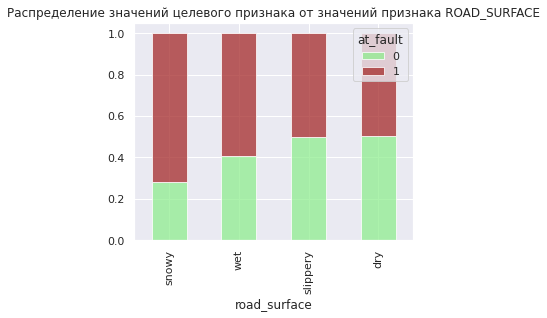

In [49]:
fig, ax = plt.subplots(figsize=(5, 4))
cross_prob_bar_prob_order('road_surface', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака ROAD_SURFACE',
    fontsize=12
)
plt.show()

**Вывод** Значения целевого признака хорошо дифференцированы в зависимости от значения `road_surface`

**`road_condition`**

In [50]:
df_raw['road_condition'].value_counts()

normal            52433
construction        987
obstruction         242
other               220
holes               215
loose material      125
reduced width        65
flooded              30
Name: road_condition, dtype: int64

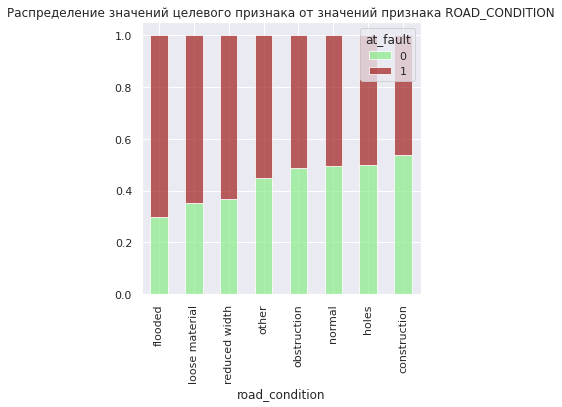

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
cross_prob_bar_prob_order('road_condition', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака ROAD_CONDITION',
    fontsize=12
)
plt.show()

**Вывод** Значения целевого признака хорошо дифференцированы в зависимости от значения `road_condition`.

**`lighting`**

In [52]:
df_raw['lighting'] = df_raw['lighting'].map(
    dict(
        zip(
            df_raw['lighting'].value_counts().index,
            [
                'daylight',
                'dark str lights',
                'dark no str lights',
                'dusk or dawn',
                'dark str lights not function'
            ]
        )
    )
)

In [53]:
df_raw['lighting'].value_counts()

daylight                        36907
dark str lights                 10599
dark no str lights               5045
dusk or dawn                     1720
dark str lights not function      131
Name: lighting, dtype: int64

Имеет смысл объединить категории `dark no str lights` и `dark str lights not function` так как по сути это одно и то же.

In [54]:
df_raw.loc[df_raw[df_raw['lighting'] == 'dark str lights not function'].index, 'lighting'] = 'dark no str lights'

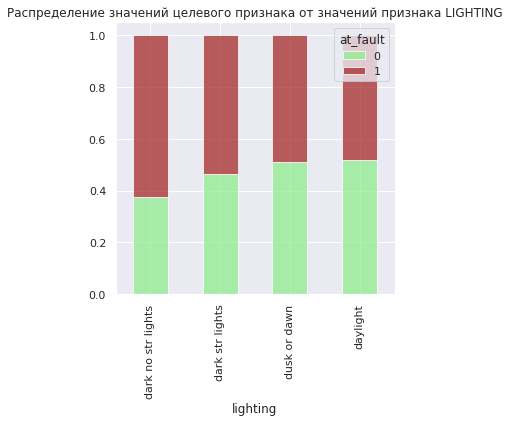

In [55]:
ig, ax = plt.subplots(figsize=(5, 5))
cross_prob_bar_prob_order('lighting', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака LIGHTING',
    fontsize=12
)
plt.show()

**Вывод** значения целевого признака хорошо дифференцированы в зависимости от значения `lighting`

**`day_of_week`**

In [56]:
df_raw['day_of_week'].value_counts()

saturday     9126
friday       8981
sunday       7867
thursday     7466
wednesday    7320
tuesday      6945
monday       6849
Name: day_of_week, dtype: int64

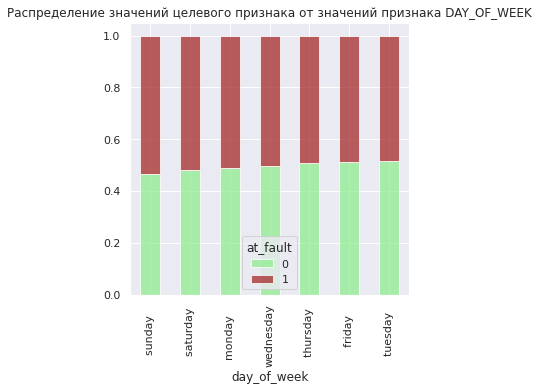

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))
cross_prob_bar_prob_order('day_of_week', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака DAY_OF_WEEK',
    fontsize=12
)
plt.show()

**Вывод** значения целевого признака слабо дифференцированы в зависимости от значения `day_of_week`. <font color='red'>**отклоняем**</font>

**`hour`**

In [58]:
df_raw['hour'].value_counts().sort_index()

0.0000     1035
1.0000     1103
2.0000     1139
3.0000      693
4.0000      492
5.0000      668
6.0000     1091
7.0000     2482
8.0000     2454
9.0000     1968
10.0000    2246
11.0000    2779
12.0000    3213
13.0000    3456
14.0000    3972
15.0000    4730
16.0000    4031
17.0000    4112
18.0000    3590
19.0000    2468
20.0000    2089
21.0000    1826
22.0000    1501
23.0000    1332
Name: hour, dtype: int64

In [59]:
df_raw['time_cat'] = pd.cut(df_raw['hour'] , 4, labels=['night', 'morning', 'day', 'evening'])

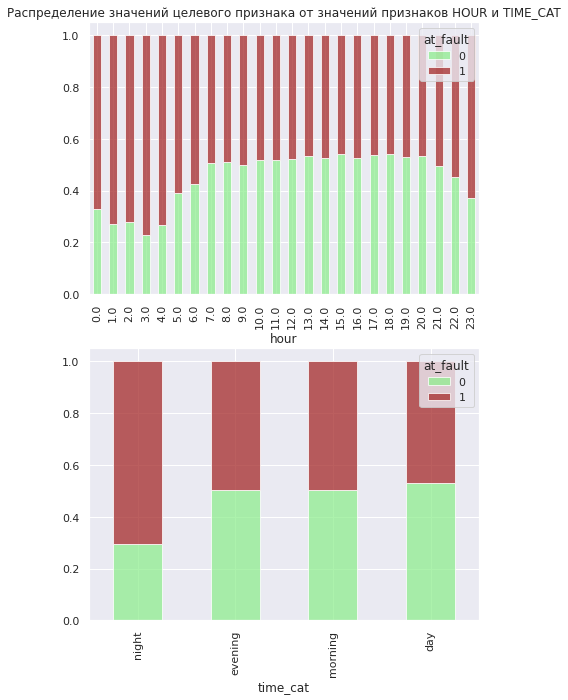

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(7, 11))
cross_prob_bar('hour', ax[0])
cross_prob_bar_prob_order('time_cat', ax[1])
ax[0].set_title(
    'Распределение значений целевого признака от значений признаков HOUR и TIME_CAT',
    fontsize=12
)
plt.show()

**Вывод** признак `hour` переведен в признак с меньшим числом значений `time_cat`, значения целевого признака хорошо дифференцированы в зависимости от значения `time_cat`

**`insurance_premium`**

In [61]:
df_raw['insurance_premium'].nunique()

102

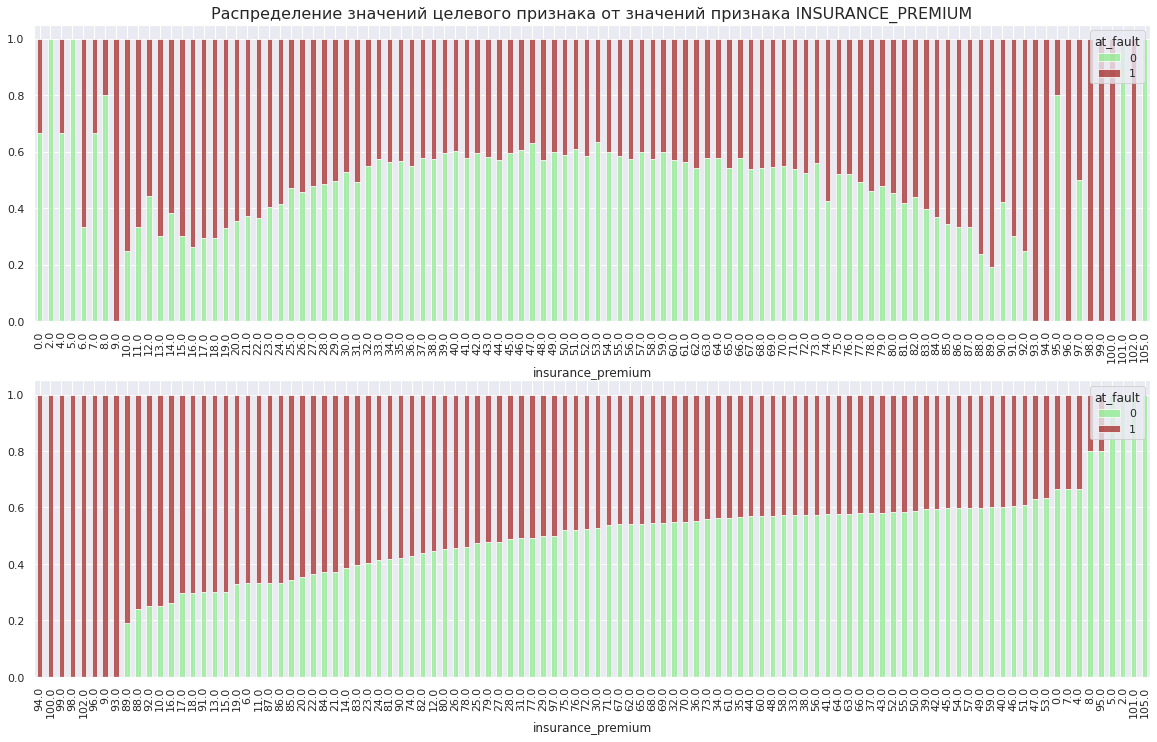

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

cross_prob_bar('insurance_premium', ax[0])
cross_prob_bar_prob_order('insurance_premium', ax[1])
ax[0].set_title(
    'Распределение значений целевого признака от значений признака INSURANCE_PREMIUM',
    fontsize=16
)
plt.show()

**Вывод:** C одной стороны - хорошая корреляция с целевым признаком, с другой - числовое значение не является индикатором роста или снижения вероятности, что водитель - виновник ДТП.

**`cellphone_in_use`**

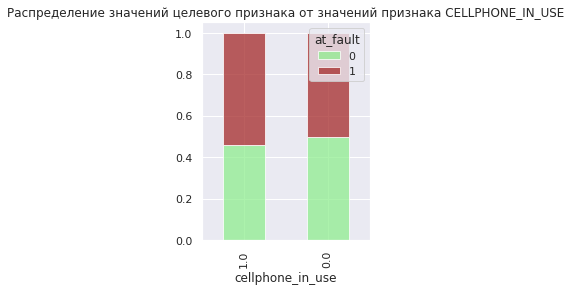

In [63]:
fig, ax = plt.subplots(figsize=(3, 4))

cross_prob_bar_prob_order('cellphone_in_use', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака CELLPHONE_IN_USE',
    fontsize=12
)
plt.show()

**Вывод:** слабый признак. Также нужно учесть, что в столбце `cellphone_in_use` присутствует 6114 пропуска, которые не представляется возможным восстановить. <font color='red'>**отклоняем**</font>

**`vehicle_type`**

In [64]:
df_raw['vehicle_type'].value_counts()

sedan    35515
coupe    19035
other        4
Name: vehicle_type, dtype: int64

Лучше удалить значения `other`, так как их частота крайне мала по сравнению с остальными.

In [65]:
df_raw = df_raw.drop(
    df_raw.query('vehicle_type not in ["sedan", "coupe", "hatchback", "minivan"]').index,
    axis=0
)

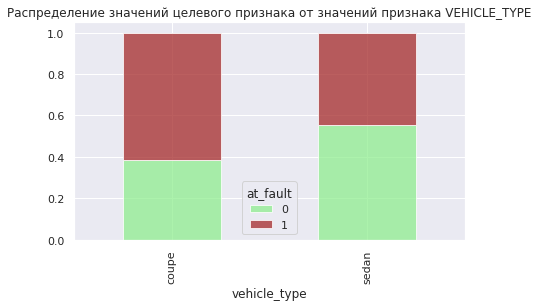

In [66]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar_prob_order('vehicle_type', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака VEHICLE_TYPE',
    fontsize=12
)
plt.show()

**Вывод:** значения целевого признака хорошо дифференцированы в зависимости от значения `vehicle_type`

**`vehicle_transmission`**

In [67]:
df_raw['vehicle_transmission'].value_counts()

manual    28588
auto      25387
Name: vehicle_transmission, dtype: int64

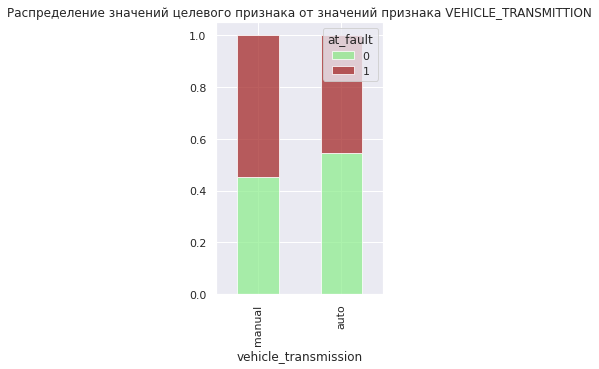

In [68]:
fig, ax = plt.subplots(figsize=(3, 5))

cross_prob_bar_prob_order('vehicle_transmission', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака VEHICLE_TRANSMITTION',
    fontsize=12
)
plt.show()

Разница около 10 процентных пунктов. Логика на диаграмме есть: с ручной коробкой передач сложнее обращаться, чем с автоматической. Водители автомобилей с ручной коробкой могут совершать ошибки, связанные с управлениям коробкой, которые приводят к ДТП.

**Вывод:** значения целевого признака хорошо дифференцированы в зависимости от значения `vehicle_transmission`

#### Выбранные признаки

**`county_location`**

In [69]:
df_raw['county_location'].value_counts()

los angeles        15714
orange              5078
san diego           3675
san bernardino      3592
riverside           3205
sacramento          2116
alameda             1838
santa clara         1778
ventura             1441
kern                1389
fresno              1057
contra costa         956
san mateo            915
san joaquin          892
stanislaus           786
santa barbara        704
tulare               700
sonoma               677
placer               557
monterey             550
solano               540
san francisco        483
san luis obispo      428
santa cruz           421
merced               383
marin                361
madera               320
humboldt             319
butte                312
el dorado            286
shasta               275
yolo                 266
kings                244
napa                 208
imperial             205
mendocino            189
nevada               181
tehama               145
sutter               143
tuolumne             122


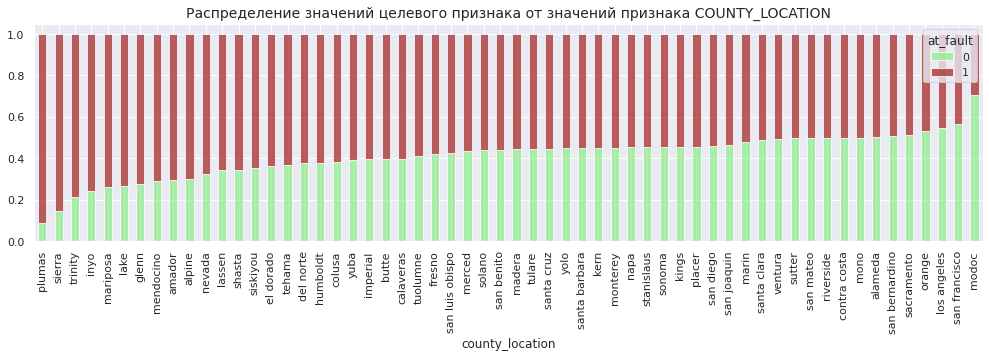

In [70]:
fig, ax = plt.subplots(figsize=(17, 4))

cross_prob_bar_prob_order('county_location', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака COUNTY_LOCATION',
    fontsize=14
)
plt.show()

**Вывод** значения целевого признака хорошо дифференцированы в зависимости от значения `county_location`

**`weather`**

Заполним пропуски в этом столбце значением `other`

In [71]:
df_raw['weather'] = df_raw['weather'].fillna('other')

In [72]:
df_raw['weather'].value_counts()

clear      43725
cloudy      8177
raining     2115
other        195
fog          173
snowing      154
wind          11
Name: weather, dtype: int64

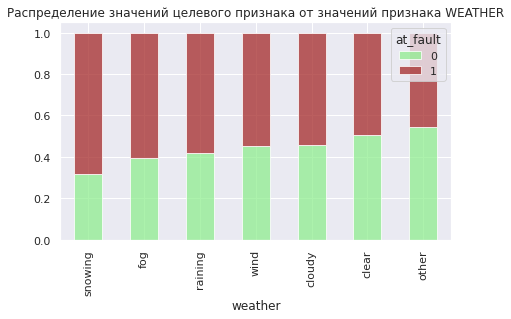

In [73]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar_prob_order('weather', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака WEATHER',
    fontsize=12
)
plt.show()

**Вывод** значения целевого признака хорошо дифференцированы в зависимости от значения `weather`.

**`type_of_collision`**

In [74]:
df_raw['type_of_collision'].value_counts()

rear end      18252
broadside     11499
sideswipe      8887
hit object     8490
head-on        3211
overturned     2281
other          1641
Name: type_of_collision, dtype: int64

Заполним пропуски в этом столбце значением `other`

In [75]:
df_raw['type_of_collision'] = df_raw['type_of_collision'].fillna('other')

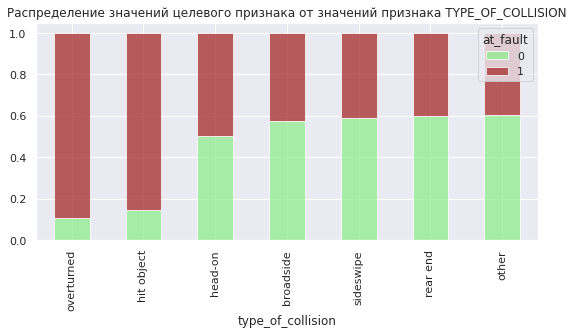

In [76]:
fig, ax = plt.subplots(figsize=(9, 4))

cross_prob_bar_prob_order('type_of_collision', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака TYPE_OF_COLLISION',
    fontsize=12
)
plt.show()

**Вывод:** для значений `overturned` и `hit object` вероятность быть признанным виновником ДТП крайне высокая.

**`motor_vehicle_involved_with`**

In [77]:
df_raw['motor_vehicle_involved_with'].value_counts()

other motor vehicle               39906
fixed object                       8133
non-collision                      2254
other object                       1653
parked motor vehicle               1443
motor vehicle on other roadway      395
bicycle                             377
animal                              228
train                                15
Name: motor_vehicle_involved_with, dtype: int64

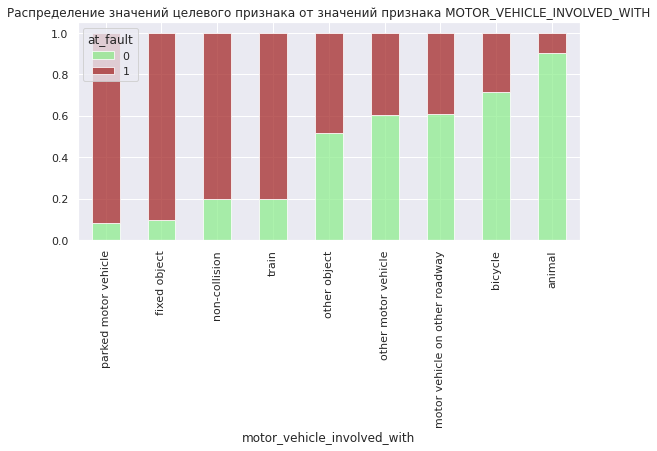

In [78]:
fig, ax = plt.subplots(figsize=(9, 4))

cross_prob_bar_prob_order('motor_vehicle_involved_with', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака MOTOR_VEHICLE_INVOLVED_WITH',
    fontsize=12)
plt.show()

In [79]:
print(f'В столбце {df_raw["motor_vehicle_involved_with"].isna().sum()} пропусков')

В столбце 146 пропусков


В данном случае среди существующих значений признака трудно выбрать наиболее подходящее для заполнения. В дальнейшем удалим пропуски.

**Вывод:** отличный признак!

**`party_sobriety`**

In [80]:
df_raw['party_sobriety'].value_counts()

had not been drinking                     47186
had been drinking, under influence         4384
impairment unknown                         1095
had been drinking, not under influence      564
had been drinking, impairment unknown       249
not applicable                              237
Name: party_sobriety, dtype: int64

In [81]:
print(f'В столбце {df_raw["party_sobriety"].isna().sum()} пропусков')

В столбце 835 пропусков


Вероятно, данные не внесены, так как процедуру не проводили. Заполняем пропуски значением `not applicable`

In [82]:
df_raw['party_sobriety'] = df_raw['party_sobriety'].fillna('not applicable')

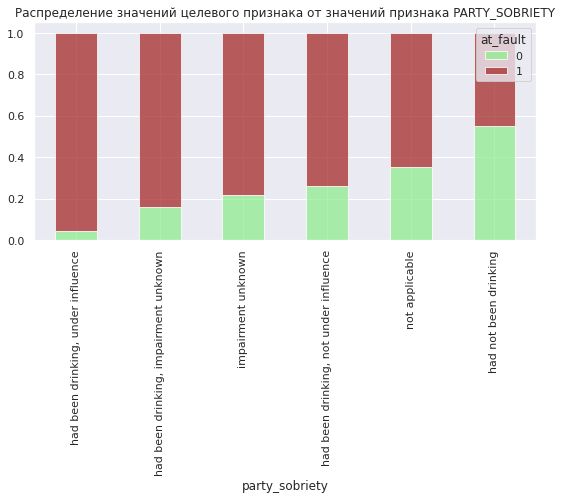

In [83]:
fig, ax = plt.subplots(figsize=(9, 4))

cross_prob_bar_prob_order('party_sobriety', ax)
ax.set_title(
    'Распределение значений целевого признака от значений признака PARTY_SOBRIETY',
    fontsize=12
)
plt.show()

**Вывод:** хороший признак!

**`vehicle_age`**

In [84]:
df_raw['vehicle_age'].value_counts()

3      11011
4       7157
2       6047
5       5565
6       3939
7       3838
8       3509
0       3087
9       2769
1       2545
10      1942
11      1380
12       879
13       551
14       282
15        37
16         6
17         3
161        2
19         1
Name: vehicle_age, dtype: int64

In [85]:
df_raw[df_raw['vehicle_age']==161][['case_id',
                                    'vehicle_type',
                                    'vehicle_transmission',
                                    'collision_date']
                                  ]

,case_id,vehicle_type,vehicle_transmission,collision_date
52744,5542342,sedan,manual,2012-06-20
54379,5639033,sedan,manual,2012-12-05


Всего 20 различных значений. Есть аномальное значение 161. Вероятнее всего опечатка. Удаляем.

In [86]:
df_raw.drop(index=df_raw[df_raw['vehicle_age'] > 50].index, inplace=True)

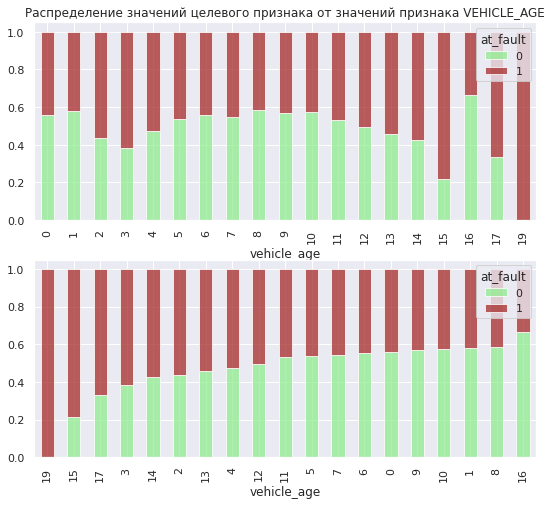

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(9, 8))

cross_prob_bar('vehicle_age', ax[0])
cross_prob_bar_prob_order('vehicle_age', ax[1])
ax[0].set_title(
    'Распределение значений целевого признака от значений признака VEHICLE_AGE',
    fontsize=12
)
plt.show()

**Вывод:** C одной стороны - хорошая корреляция с целевым признаком, с другой - числовое значение не является индикатором роста или снижения вероятности, что водитель - виновник ДТП.

#### Финальный датасет

Для модели выбраны 11 признаков и целевой `at_fault`:

In [88]:
cols4model = ['at_fault',
#               'party_count', 
              'road_condition',
              'road_surface',
              'lighting',
              'time_cat',
              'insurance_premium',
              'vehicle_type',
              'vehicle_transmission',
              'weather',
              'county_location',
              'vehicle_age',
#               'type_of_collision', 
#               'motor_vehicle_involved_with', 
              'party_sobriety']

In [89]:
df = df_raw[df_raw['vehicle_age'] <= 10][cols4model].copy()
# df = df_raw[cols4model].copy()

In [90]:
df.head()

,at_fault,road_condition,road_surface,lighting,time_cat,insurance_premium,vehicle_type,vehicle_transmission,weather,county_location,vehicle_age,party_sobriety
0,0,normal,dry,dark no str lights,night,46.0000,sedan,auto,clear,san bernardino,9,had not been drinking
1,1,normal,dry,dark no str lights,night,60.0000,sedan,manual,clear,fresno,8,"had been drinking, under influence"
2,0,normal,dry,dark str lights,night,38.0000,coupe,auto,clear,los angeles,6,had not been drinking
3,1,normal,dry,dark str lights,night,19.0000,coupe,manual,clear,ventura,3,"had been drinking, under influence"
4,0,normal,dry,dark str lights,night,36.0000,sedan,auto,clear,los angeles,2,had not been drinking


<div class="alert alert-success">
<b>👍 Успех:</b> Отличный набор признаков!
</div>

Проведем стандартные проверки и выведем общую информацию о данных:

In [91]:
df.shape

(51409, 12)

In [92]:
df.duplicated().sum()

10076

In [93]:
df = df.drop_duplicates()
df.shape

(41333, 12)

In [94]:
df.isna().sum()

at_fault                  0
road_condition          220
road_surface            304
lighting                145
time_cat                 80
insurance_premium       376
vehicle_type              0
vehicle_transmission    527
weather                   0
county_location           0
vehicle_age               0
party_sobriety            0
dtype: int64

In [95]:
df = df.dropna()
df.shape

(39816, 12)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39816 entries, 0 to 54553
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              39816 non-null  int64   
 1   road_condition        39816 non-null  object  
 2   road_surface          39816 non-null  object  
 3   lighting              39816 non-null  object  
 4   time_cat              39816 non-null  category
 5   insurance_premium     39816 non-null  float64 
 6   vehicle_type          39816 non-null  object  
 7   vehicle_transmission  39816 non-null  object  
 8   weather               39816 non-null  object  
 9   county_location       39816 non-null  object  
 10  vehicle_age           39816 non-null  int64   
 11  party_sobriety        39816 non-null  object  
dtypes: category(1), float64(1), int64(2), object(8)
memory usage: 3.7+ MB


Баланс классов:

In [97]:
(
    df['at_fault'].value_counts().to_frame()
    .assign(percent = lambda x: round(x / x['at_fault'].sum()*100, 1) )
)

,at_fault,percent
1,20462,51.4000
0,19354,48.6000


In [98]:
df.describe(include=['integer', 'float'])

,at_fault,insurance_premium,vehicle_age
count,39816.0000,39816.0000,39816.0000
mean,0.5139,36.6263,4.4961
std,0.4998,14.5668,2.6812
min,0.0000,0.0000,0.0000
25%,0.0000,24.0000,3.0000
50%,1.0000,34.0000,4.0000
75%,1.0000,47.0000,7.0000
max,1.0000,105.0000,10.0000


In [99]:
df.describe(include='object').T

,count,unique,top,freq
road_condition,39816,8,normal,38195
road_surface,39816,4,dry,34788
lighting,39816,4,daylight,25667
vehicle_type,39816,2,sedan,26976
vehicle_transmission,39816,2,manual,21181
weather,39816,7,clear,30266
county_location,39816,58,los angeles,8546
party_sobriety,39816,6,had not been drinking,33806


Фактически у нас все данные типа `object` являются категориальными. Изменим тип данных:

In [100]:
df[df.describe(include='object').columns] = df[
    df.describe(include='object').columns
].astype('category')

Оптимизируем типы числовых данных:

In [101]:
data_int = df.select_dtypes(include=['integer', 'float']
                           ).apply(pd.to_numeric, downcast='unsigned')
for item in data_int.dtypes.index:
    df[item] = df[item].astype(data_int.dtypes[item])

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39816 entries, 0 to 54553
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   at_fault              39816 non-null  uint8   
 1   road_condition        39816 non-null  category
 2   road_surface          39816 non-null  category
 3   lighting              39816 non-null  category
 4   time_cat              39816 non-null  category
 5   insurance_premium     39816 non-null  uint8   
 6   vehicle_type          39816 non-null  category
 7   vehicle_transmission  39816 non-null  category
 8   weather               39816 non-null  category
 9   county_location       39816 non-null  category
 10  vehicle_age           39816 non-null  uint8   
 11  party_sobriety        39816 non-null  category
dtypes: category(9), uint8(3)
memory usage: 781.9 KB


Данные для модели подготовлены. 
- Датасет содержит `39 816` записей в `13` столбцах (12 признаков, 1 целевой), классы сбалансированы, пропусков нет, дубликатов нет. 
- Типы данных: `category(9)`, `uint8(3)`.
<!-- - Размер 1.2 MB. -->

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

####   Разбиение на тренировочные и тестовые данные

In [103]:
fch = df.drop('at_fault', axis=1)
trgt = df['at_fault']

fch_train, fch_test, trgt_train, trgt_test = train_test_split(
    fch, trgt, test_size=TST_SZE, random_state=RND_ST
)

#### Выбор метрики

Для оценки моделей выбираем метрику `f1`. Важно минимизировать ошибку 1-го рода и как можно точнее прогнозировать действительно тех, кто является нарушителем (максимум `Precision`), а также выявлять как можно большее число виновников (максимум `Recall`).

<div class="alert alert-success">
<b>👍 Успех:</b> Метрика выбрана верно!
</div>

**CatBoostClassifier**

**Базовая модель**

Замерим метрики "базовой" модели на кроссвалидации:

In [104]:
cat_columns = df.select_dtypes(include='category').columns.values
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RND_ST)

In [105]:
CBCPool_train = Pool(data=fch_train,
                     label=trgt_train,
                     cat_features=cat_columns)
base_params_cbc = {'loss_function':'Logloss',
                   'random_state': RND_ST,
                   'eval_metric': 'F1',
                   'verbose': False}

In [106]:
cv_CBC_base_scores = cv(CBCPool_train,
                        base_params_cbc,
                        folds=kf,
                        early_stopping_rounds=25,
                        plot=True,
                        verbose=False)

print('CatBoost_base')
CBCModel_base_CV_score = cv_CBC_base_scores['test-F1-mean'].max()
print(f"Среднее значение F1 = {round(CBCModel_base_CV_score, 4)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6246128769
bestIteration = 0

Training on fold [1/5]

bestTest = 0.6035665295
bestIteration = 1

Training on fold [2/5]

bestTest = 0.6221113882
bestIteration = 1

Training on fold [3/5]

bestTest = 0.6327757025
bestIteration = 0

Training on fold [4/5]

bestTest = 0.6266122449
bestIteration = 0

CatBoost_base
Среднее значение F1 = 0.6215


Переведем данные в столбцах <!-- `party_count`,  --> `insurance_premium` и `vehicle_age` в категориальный тип, попробуем с таким датасетом:

In [107]:
fch_train_all_cat = fch_train.copy()
fch_test_all_cat = fch_test.copy()

fch_train_all_cat[fch_train_all_cat.describe(include='integer').columns] = (
    fch_train_all_cat[fch_train_all_cat.describe(include='integer').columns]
    .astype(str)
    .astype('category')
)

fch_test_all_cat[fch_test_all_cat.describe(include='integer').columns] = (
    fch_test_all_cat[fch_test_all_cat.describe(include='integer').columns]
    .astype(str)
    .astype('category')
)

cat_columns_all_cat = fch_train_all_cat.select_dtypes(include='category').columns.values
CBCPool_train_all_cat = Pool(data=fch_train_all_cat,
                             label=trgt_train,
                             cat_features=cat_columns_all_cat)

In [108]:
cv_CBC_base_all_cat_scores = cv(CBCPool_train_all_cat,
                                base_params_cbc,
                                folds=kf,
                                early_stopping_rounds=25,
                                plot=True,
                                verbose=False, )

print('CatBoost_base (all_cat)')
CBCModel_base_all_cat_CV_score = cv_CBC_base_all_cat_scores['test-F1-mean'].max()
print(f"Среднее значение F1 = {round(CBCModel_base_all_cat_CV_score, 4)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6026064292
bestIteration = 15

Training on fold [1/5]

bestTest = 0.6055749129
bestIteration = 23

Training on fold [2/5]

bestTest = 0.6135622318
bestIteration = 220

Training on fold [3/5]

bestTest = 0.6089733355
bestIteration = 0

Training on fold [4/5]

bestTest = 0.6203355015
bestIteration = 186

CatBoost_base (all_cat)
Среднее значение F1 = 0.6087


In [109]:
pd.DataFrame([[CBCModel_base_CV_score],
              [CBCModel_base_all_cat_CV_score]],
             columns=['F1'],
             index=['CatBoost_base', 'CatBoost_base (all_cat)']
            ).sort_values(by='F1', ascending=False)

,F1
CatBoost_base,0.6215
CatBoost_base (all_cat),0.6087


<!-- **Вывод:** для `CatBoost` лучше использовать первый датасет (`base`) -->

**Подбор гиперпараметров**

Найдем оптимальные гиперпараметры с помощью `Optuna`

In [110]:
def objective_CBC(trial, features=fch_train, target=trgt_train): #  fch_train_all_cat
    
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, test_size=TST_SZE, random_state=RND_ST
    )
    cat_cols = features.select_dtypes(include='category').columns.values
    Pool_trn = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    Pool_val = Pool(data=X_val, label=y_val, cat_features=cat_cols)
    params = {
        'max_depth': trial.suggest_int('max_depth', 8, 9, 10),
        'learning_rate': trial.suggest_float('learning_rate', .1, .2),  
        'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
        'loss_function': 'Logloss',
        'eval_metric': 'F1'
    }
    model = CatBoostClassifier(
        **params,
        random_state=RND_ST
    )
    model.fit(
        Pool_trn,
        eval_set = [Pool_val],
        early_stopping_rounds=50,
        verbose=False
    )
    return model.get_best_score()['validation']['F1']

In [111]:
study_cbc = optuna.create_study(direction = 'maximize', study_name='CatBoostClassifier')
study_cbc.optimize(objective_CBC, n_trials = 25)

[I 2024-02-27 00:53:05,862] A new study created in memory with name: CatBoostClassifier
[I 2024-02-27 00:53:11,815] Trial 0 finished with value: 0.6264202136679667 and parameters: {'max_depth': 8, 'learning_rate': 0.1999207561944567, 'n_estimators': 1347}. Best is trial 0 with value: 0.6264202136679667.
[I 2024-02-27 00:53:20,647] Trial 1 finished with value: 0.6213789598509233 and parameters: {'max_depth': 8, 'learning_rate': 0.18687789263210253, 'n_estimators': 1250}. Best is trial 0 with value: 0.6264202136679667.
[I 2024-02-27 00:53:26,615] Trial 2 finished with value: 0.623806275579809 and parameters: {'max_depth': 8, 'learning_rate': 0.18855157366625927, 'n_estimators': 1328}. Best is trial 0 with value: 0.6264202136679667.
[I 2024-02-27 00:53:34,389] Trial 3 finished with value: 0.624283305227656 and parameters: {'max_depth': 8, 'learning_rate': 0.16991197702204758, 'n_estimators': 1097}. Best is trial 0 with value: 0.6264202136679667.
[I 2024-02-27 00:53:42,735] Trial 4 finishe

In [112]:
study_cbc.best_params

{'max_depth': 8, 'learning_rate': 0.12917794242609787, 'n_estimators': 1333}

In [113]:
study_cbc.best_trial.value 

0.6274575701562762

**CV модели с лучшими гиперпараметрами**

In [114]:
best_params_cbc = study_cbc.best_params
best_params_cbc.update(base_params_cbc)

In [115]:
cv_CBC_best_scores = cv(CBCPool_train, # CBCPool_train_all_cat,
                        best_params_cbc,
                        folds=kf,
                        early_stopping_rounds=25,
                        plot=True,
                        verbose=False)

print('CatBoostClassifier_tuned (base)')
CBCModel_best_CV_score = cv_CBC_best_scores['test-F1-mean'].max()
print(f"Среднее значение F1 = {round(CBCModel_best_CV_score, 4)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6246128769
bestIteration = 0

Training on fold [1/5]

bestTest = 0.605987195
bestIteration = 14

Training on fold [2/5]

bestTest = 0.6210196337
bestIteration = 0

Training on fold [3/5]

bestTest = 0.6327757025
bestIteration = 0

Training on fold [4/5]

bestTest = 0.6266122449
bestIteration = 0

CatBoostClassifier_tuned (base)
Среднее значение F1 = 0.6214


Собираем всю статистику по `CatBoostClassifier` вместе.

In [116]:
CBC_stat = pd.DataFrame(
    [
        [CBCModel_base_CV_score],
        [CBCModel_base_all_cat_CV_score],
        [CBCModel_best_CV_score]
    ],
    columns=['F1'],
    index=['CatBoost_base_cv', 'CatBoost_base_(all_cat)_cv', 'CatBoost_tuned_cv']
)
display(CBC_stat.sort_values(by='F1', ascending=False))

,F1
CatBoost_base_cv,0.6215
CatBoost_tuned_cv,0.6214
CatBoost_base_(all_cat)_cv,0.6087


**Вывод:**<br>
Для модели `CatBoostClassifier` оптимально использовать параметры по-умолчанию. 
<!-- Оптимальные гиперпараметры модели выбраны с помощью `Optuna`,  -->
Получена метрика для модели с оптимальными гиперпараметрами на кроссвалидации на тренировочных данных.

<div class="alert alert-success">
<b>👍 Успех:</b> Хорошая работа! Присмотрись к использованию RandomizedSearchCV, этот способ довольно быстро работает и хорошо справляется с подбором параметров, мне нравится именно из-за скорости))) 
    
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
</div>

**LGBMClassifier**

**Базовая модель**

Замерим метрики "базовой" модели на кроссвалидации:

In [117]:
def lgb_f1(preds, data):
    y_true = data.get_label()
    preds = np.where(preds < 0.5, 0, 1) 
    return 'f1', f1_score(y_true, preds), True

In [118]:
base_params_lgb = {'objective': 'binary',
                   'verbose': -1,
                   'seed': RND_ST
                  }

lgbDS_train = lgb.Dataset(data=fch_train,
                          label=trgt_train,
                          params={'verbose': -1},
                          categorical_feature=list(cat_columns)
                         )

In [119]:
cv_LGB_base_scores = lgb.cv(base_params_lgb,
                            lgbDS_train,
                            folds=kf,
                            feval=lgb_f1,
                            seed=RND_ST)

print('LGBMClassifier_base')
LGBModel_base_CV_score = cv_LGB_base_scores['f1-mean'][0]
print(f"Среднее значение F1: {round(LGBModel_base_CV_score, 4)}")

LGBMClassifier_base
Среднее значение F1: 0.6801


In [120]:
lgbDS_train_all_cat = lgb.Dataset(data=fch_train_all_cat,
                                  label=trgt_train,
                                  params={'verbose': -1},
                                  categorical_feature=list(cat_columns_all_cat)
                                 )

In [121]:
cv_LGB_base_all_cat_scores = lgb.cv(base_params_lgb,
                                    lgbDS_train_all_cat,
                                    folds=kf,
                                    feval=lgb_f1,
                                    seed=RND_ST)

print('LGBMClassifier_base (all cat)')
LGBModel_base_all_cat_CV_score = cv_LGB_base_all_cat_scores['f1-mean'][0]
print(f"Среднее значение F1: {round(LGBModel_base_all_cat_CV_score, 4)}")

LGBMClassifier_base (all cat)
Среднее значение F1: 0.6778


In [122]:
pd.DataFrame([[LGBModel_base_CV_score],
              [LGBModel_base_all_cat_CV_score]],
             columns=['F1'],
             index=['LGBM_base', 'LGBM_base (all_cat)']
            ).sort_values(by='F1', ascending=False)

,F1
LGBM_base,0.6801
LGBM_base (all_cat),0.6778


**Вывод:** для `LGBMClassifier` лучше использовать первый датасет (`int` + `category`)

**Подбор гиперпараметров**

Найдем оптимальные гиперпараметры с помощью `Optuna`

In [123]:
def objective_LGB(trial, features=fch_train, target=trgt_train):
    
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, test_size=TST_SZE, random_state=RND_ST
    )
    dtrain = lgb.Dataset(X_train,
                         label=y_train,
                         params={'verbose': -1},
                         categorical_feature=list(cat_columns)
                        )
    dval = lgb.Dataset(X_val,
                       label=y_val,
                       params={'verbose': -1},
                       categorical_feature=list(cat_columns)
                      )
    params = {'objective': 'binary',
              'verbose': -1,
              'random_state': RND_ST,
              'early_stopping_round': 50,
              'metric': None,
              'n_estimators': trial.suggest_int('n_estimators', 800, 1000),        
              'max_depth': trial.suggest_int('max_depth', 5, 7),                    
              'learning_rate': trial.suggest_float('learning_rate', .02, .04), 
              'num_leaves': trial.suggest_int('num_leaves', 50, 100),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 85, 115),
              'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1e-3),
              'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 1e-1)
             }
    evals_result ={}
    model = lgb.train(params,
                      dtrain,
                      valid_sets=[dval],
                      valid_names=['valid'],
                      feval=lgb_f1,
                      evals_result=evals_result,
                      verbose_eval=False)

    return np.max(evals_result['valid']['f1'])

In [124]:
study_lgb = optuna.create_study(direction='maximize', study_name='LGBM_Classifier')
study_lgb.optimize(objective_LGB, n_trials=15)

[I 2024-02-27 01:14:24,504] A new study created in memory with name: LGBM_Classifier
[I 2024-02-27 01:14:27,304] Trial 0 finished with value: 0.6828612776514368 and parameters: {'n_estimators': 937, 'max_depth': 5, 'learning_rate': 0.03621619674605851, 'num_leaves': 77, 'min_data_in_leaf': 104, 'lambda_l1': 0.0005277015159301558, 'lambda_l2': 0.02832799323411004}. Best is trial 0 with value: 0.6828612776514368.
[I 2024-02-27 01:14:30,109] Trial 1 finished with value: 0.6828612776514368 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.029064424638224624, 'num_leaves': 77, 'min_data_in_leaf': 115, 'lambda_l1': 0.00021427104742084916, 'lambda_l2': 0.09877010292088952}. Best is trial 0 with value: 0.6828612776514368.
[I 2024-02-27 01:14:33,719] Trial 2 finished with value: 0.6839297621693708 and parameters: {'n_estimators': 917, 'max_depth': 6, 'learning_rate': 0.03712734967422438, 'num_leaves': 95, 'min_data_in_leaf': 103, 'lambda_l1': 0.0006150623962873303, 'lambd

In [125]:
study_lgb.best_params

{'n_estimators': 805,
 'max_depth': 7,
 'learning_rate': 0.021613030650332023,
 'num_leaves': 94,
 'min_data_in_leaf': 89,
 'lambda_l1': 0.0002459579893169955,
 'lambda_l2': 0.057550352712646566}

In [126]:
study_lgb.best_trial.value

0.6882546652030734

**CV модели с лучшими гиперпараметрами**

Обучаем и тестируем модель с лучшими гиперпараметрами, сохраняем результаты.

In [127]:
best_params_lgb = study_lgb.best_params
best_params_lgb.update(base_params_lgb)

lgbDS_train = lgb.Dataset(data=fch_train,
                          label=trgt_train,
                          params={'verbose': -1},
                          categorical_feature=list(cat_columns)
                         )

In [128]:
cv_LGB_best_scores = lgb.cv(best_params_lgb,
                            lgbDS_train,
                            folds=kf,
                            feval=lgb_f1)

print('LGBMClassifier_tuned (all_cat)')
LGBModel_best_CV_score = cv_LGB_best_scores['f1-mean'][0]
print(f"Среднее значение F1: {round(LGBModel_best_CV_score, 4)}")

LGBMClassifier_tuned (all_cat)
Среднее значение F1: 0.6798


In [129]:
LGB_stat = pd.DataFrame(
    [
        [LGBModel_base_CV_score],
        [LGBModel_base_all_cat_CV_score],
        [LGBModel_best_CV_score]
    ],
    columns=['F1'],
    index=['LGBM_base_cv', 'LGBM_base_(all_cat)_cv', 'LGBM_tuned_cv']
)
display(LGB_stat.sort_values(by='F1', ascending=False))

,F1
LGBM_base_cv,0.6801
LGBM_tuned_cv,0.6798
LGBM_base_(all_cat)_cv,0.6778


**Вывод:**<br>
Для модели `LGBMClassifier` оптимально использовать датасет в исходном виде c параметрами по-умолчанию.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

**Нейронная сеть**

**Подготовка данных**

`OneHotEncoder`

In [130]:
encoder = OneHotEncoder(drop='first').fit(fch_train[cat_columns])
encoder.categories_

[array(['construction', 'flooded', 'holes', 'loose material', 'normal',
        'obstruction', 'other', 'reduced width'], dtype=object),
 array(['dry', 'slippery', 'snowy', 'wet'], dtype=object),
 array(['dark no str lights', 'dark str lights', 'daylight',
        'dusk or dawn'], dtype=object),
 array(['day', 'evening', 'morning', 'night'], dtype=object),
 array(['coupe', 'sedan'], dtype=object),
 array(['auto', 'manual'], dtype=object),
 array(['clear', 'cloudy', 'fog', 'other', 'raining', 'snowing', 'wind'],
       dtype=object),
 array(['alameda', 'alpine', 'amador', 'butte', 'calaveras', 'colusa',
        'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn',
        'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen',
        'los angeles', 'madera', 'marin', 'mariposa', 'mendocino',
        'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange',
        'placer', 'plumas', 'riverside', 'sacramento', 'san benito',
        'san bernardino', 'san dieg

После кодирования должно получиться столбцов:

In [131]:
sum([(len(item)-1) for item in encoder.categories_])

86

In [132]:
train_ohe = encoder.transform(fch_train[cat_columns]).toarray()
test_ohe = encoder.transform(fch_test[cat_columns]).toarray()
train_ohe.shape, test_ohe.shape

((31852, 86), (7964, 86))

`StandardScaler`

In [133]:
col2scl = np.setdiff1d(fch_train.columns, cat_columns, assume_unique=False)
scaler = StandardScaler().fit(fch_train[col2scl])

In [134]:
train_scl = scaler.transform(fch_train[col2scl])
test_scl = scaler.transform(fch_test[col2scl])
train_scl.shape, test_scl.shape

((31852, 2), (7964, 2))

**Объединение в тензоры**

In [135]:
nn_train = np.concatenate((train_ohe, train_scl), axis=1)
nn_test = np.concatenate((test_ohe, test_scl), axis=1)
X_trn = torch.FloatTensor(nn_train)
X_tst = torch.FloatTensor(nn_test)
y_trn = torch.FloatTensor(trgt_train.values)
y_tst = torch.FloatTensor(trgt_test.values)

In [136]:
X_trn.size(), X_tst.size()

(torch.Size([31852, 88]), torch.Size([7964, 88]))

Тренировочные и тестовые данные обработаны классами `OneHotEncoder` и `StandardScaler`, конвертированы в тензоры.

**Построение нейронной сети**

In [137]:
class NNet(nn.Module):
    
    '''
    Класс строит полносвязную нейронную сеть произвольной конфигурации
    Параметры слоёв задается элементами тензора net
    Коэффициенты dropout для внутренних слоёв задаются элементами тензора dropout
    Нормализация добавляется, если batch_norm = True
    '''
    
    def __init__(self, net_tensor, dropout_tensor, batch_norm=False):
        super(NNet, self).__init__()
        
        self.net_layers = []
        
        for i in range(1, net_tensor.size()[0]-1):
            self.net_layers.append( nn.Linear(net_tensor[i-1].item(), net_tensor[i].item()) )
            if batch_norm:
                self.net_layers.append( nn.BatchNorm1d(net_tensor[i].item()) )
            self.net_layers.append( nn.ReLU() )
            self.net_layers.append( nn.Dropout(dropout_tensor[i-1].item()) )
        self.net_layers.append( nn.Linear(net_tensor[-2].item(), net_tensor[-1].item())) 
        self.net_layers.append( nn.Sigmoid() )
        
        self.net = nn.Sequential(*self.net_layers)
        
    def forward(self, X_batch):
        out = self.net.forward(X_batch)
        return out

In [138]:
def init_weights(layer):
    
    '''Функция активации начальных параметров (веса, смещения)'''
    
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        ) 
        nn.init.normal_(
            layer.bias,
            mean=0,
            std=1
        )

In [139]:
'''Определяет число нейронов по слоям (входной слой по кол-ву признаков, выходной слой = 1)'''

net_tensor = torch.ByteTensor([X_trn.size()[1], 64, 64, 32, 32, 16, 1])

**Оптимизация нейронной сети**

Находим параметры DropOut, оптимальный размер батча и темп обучения

In [140]:
param_grid = {'module__net_tensor': [net_tensor],
              'module__dropout_tensor':
              [
                  torch.FloatTensor([.2, .2, .1, .1, .0]),
                  torch.FloatTensor([.4, .3, .2, .1, .0])
              ],
              'module__batch_norm':[True],
              'batch_size':[150, 100],
              'lr':[.005, .0025]
             }

In [141]:
random.seed(RND_ST)
np.random.seed(RND_ST)
torch.manual_seed(RND_ST)
torch.use_deterministic_algorithms(True)

skorch_cls = NeuralNetClassifier(module=NNet,
                                 criterion = nn.BCEWithLogitsLoss,
                                 optimizer=torch.optim.Adam,
                                 max_epochs=50,
                                 verbose=0)

In [142]:
kf_net = KFold(n_splits=3, shuffle=True, random_state=RND_ST)

grid = GridSearchCV(skorch_cls,
                    param_grid,
                    cv=kf_net,
                    scoring='f1',
                    verbose=4,
                    error_score='raise')

grid.fit(X_trn.numpy().astype('float32'),
         y_trn.numpy().astype('float32').reshape(-1, 1)
        )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END batch_size=150, lr=0.005, module__batch_norm=True, module__dropout_tensor=tensor([0.2000, 0.2000, 0.1000, 0.1000, 0.0000]), module__net_tensor=tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8); total time= 1.8min
[CV 2/3] END batch_size=150, lr=0.005, module__batch_norm=True, module__dropout_tensor=tensor([0.2000, 0.2000, 0.1000, 0.1000, 0.0000]), module__net_tensor=tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8); total time= 1.8min
[CV 3/3] END batch_size=150, lr=0.005, module__batch_norm=True, module__dropout_tensor=tensor([0.2000, 0.2000, 0.1000, 0.1000, 0.0000]), module__net_tensor=tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8); total time= 1.8min
[CV 1/3] END batch_size=150, lr=0.005, module__batch_norm=True, module__dropout_tensor=tensor([0.4000, 0.3000, 0.2000, 0.1000, 0.0000]), module__net_tensor=tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8); total time= 1.8min
[CV 2/3] END

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise',
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.NNet'>,
),
             param_grid={'batch_size': [150, 100], 'lr': [0.005, 0.0025],
                         'module__batch_norm': [True],
                         'module__dropout_tensor': [tensor([0.2000, 0.2000, 0.1000, 0.1000, 0.0000]),
                                                    tensor([0.4000, 0.3000, 0.2000, 0.1000, 0.0000])],
                         'module__net_tensor': [tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8)]},
             scoring='f1', verbose=4)

In [143]:
grid.best_params_

{'batch_size': 150,
 'lr': 0.005,
 'module__batch_norm': True,
 'module__dropout_tensor': tensor([0.2000, 0.2000, 0.1000, 0.1000, 0.0000]),
 'module__net_tensor': tensor([88, 64, 64, 32, 32, 16,  1], dtype=torch.uint8)}

In [144]:
grid.best_score_

0.6797892581204511

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

**Функции для обучения и построения кривой обучения**

In [145]:
def net_train(net_model,
              f_train, t_train,
              f_val, t_val,
              num_epochs, batch_size, lr,
              mode = 'validation',
              frq=1, verbose=True, rtrn=True, best_only=False):
    
    '''
    Функция обучения сети
    Возвращает статистику обучения (по эпохам) в виде тензора: 
    - номер эпохи,
    - f1 на трейне, 
    - f1 на валидации.
    Возвращает лучшие показатели на валидации в виде тензора:
    - номер эпохи,
    - f1 на валидации.
    Возвращает обученную модель.
    Выводит данные обучения. Частота вывода задается параметром frq
    Вывод данных параметром verbose.
    '''
    
    loss_func = nn.BCELoss()
    learning_rate = lr
    optimizer = torch.optim.Adam(net_model.parameters(), lr=learning_rate)
    num_batches = ceil(len(f_train)/batch_size)
    stat = []
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(f_train))
        
        net_model.train()                                                                     
        for batch_idx in range(num_batches):
            
            start_index = batch_idx * batch_size
            batch_indexes = order[start_index : start_index + batch_size]
            X_batch = f_train[batch_indexes]
            y_batch = t_train[batch_indexes]
        
            optimizer.zero_grad()
            preds = net_model.forward(X_batch).flatten()
            loss_value = loss_func(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        net_model.eval()
        with torch.no_grad():                              
            trn_preds = np.rint(
                net_model.forward(f_train).flatten().detach().numpy()
            )
            val_preds = np.rint(
                net_model.forward(f_val).flatten().detach().numpy()
            )
            
            f1_trn = f1_score(t_train.flatten().detach().numpy(), trn_preds)
            f1_val = f1_score(t_val.flatten().detach().numpy(), val_preds)
            stat.append([epoch, f1_trn, f1_val])        
        
        if (epoch % frq == 0 or epoch == num_epochs -1) & verbose:
            print('epoch =', epoch,
                  '\t',
                  'f1(train) =',
                  '{0:0.6f}'.format(f1_trn),
                  '\t',
                  'f1(' + mode + ') =',
                  '{0:0.6f}'.format(f1_val) )
    
    stat_t = torch.Tensor(stat)
    best_result = torch.max(stat_t[:, 2], dim=0, keepdim=False)
    print('\nЛучший показатель f1(' + mode + '):',
          '{0:0.6f}'.format(best_result.values.item()),
          ', epoch:',
          int(best_result.indices.item()),
          '\n' )
    
    if rtrn:
        if best_only:
            return best_result
        else:
            return best_result, stat_t, net_model

In [146]:
def learning_curve(df, ylim, pal='tab10'):
    
    ''' Функция построения кривых обучения и тестирования'''
    
    fig, ax = plt.subplots(figsize=(16, 7))

    sns.lineplot(data=df, palette=pal, linewidth=1, ax=ax)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(.01))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(.0025))
    ax.set_ylim(ylim[0], ylim[1])
    ax.grid(which='minor', color = 'white', linestyle = ':')
    
    
    ax.set_title('Кривые обучения', size=16)
    ax.set_xlabel('Эпоха', fontsize=14)
    ax.set_ylabel('F1', fontsize=14)
    
    plt.show()

**Вывод** для нейронной сети выбрана конфигурация, определены параметры DropOut, размера батча, темпа обучения

**Тестирование моделей**

Тестирование CatBoostClassifier

In [149]:
CBCModel_best = CatBoostClassifier(**base_params_cbc)

CBCModel_best.fit(CBCPool_train)
trgt_probes_cbc_best = CBCModel_best.predict_proba(fch_test)
trgt_preds_cbc_best = CBCModel_best.predict(fch_test)

CBC_best_TESTmetrics_all_cat = pd.DataFrame(
    data=[[f1_score(trgt_test, trgt_preds_cbc_best),
           accuracy_score(trgt_test, trgt_preds_cbc_best),
           precision_score(trgt_test, trgt_preds_cbc_best),
           recall_score(trgt_test, trgt_preds_cbc_best),
           roc_auc_score(trgt_test, trgt_probes_cbc_best[:,1])]],
    columns=['F1', 'Accuracy', 'Precision', 'Recall', 'AUC'],
    index=['CatBoost_base_test'])

CBC_best_TESTmetrics_all_cat

,F1,Accuracy,Precision,Recall,AUC
CatBoost_base_test,0.6231,0.6509,0.6934,0.5657,0.7084


Тестирование LGBMClassifier

In [150]:
lgbDS_train = lgb.Dataset(data=fch_train,
                          label=trgt_train,
                          params={'verbose': -1},
                          categorical_feature=list(cat_columns)
                         )

LGBModel_best = lgb.train(base_params_lgb,
                          lgbDS_train)

trgt_probs_lgb_best = LGBModel_best.predict(fch_test)
trgt_preds_lgb_best = np.rint(trgt_probs_lgb_best)

LGB_best_TESTmetrics = pd.DataFrame(
    data=[[f1_score(trgt_test, trgt_preds_lgb_best),
           accuracy_score(trgt_test, trgt_preds_lgb_best),
           precision_score(trgt_test, trgt_preds_lgb_best),
           recall_score(trgt_test, trgt_preds_lgb_best),
           roc_auc_score(trgt_test, trgt_probs_lgb_best)]],
    columns=['F1', 'Accuracy', 'Precision', 'Recall', 'AUC'],
    index=['LightGBM_base_test'])

LGB_best_TESTmetrics

,F1,Accuracy,Precision,Recall,AUC
LightGBM_base_test,0.6190,0.6434,0.6801,0.5679,0.7040


Тестирование нейронной сети

In [151]:
random.seed(RND_ST)
np.random.seed(RND_ST)
torch.manual_seed(RND_ST)
torch.use_deterministic_algorithms(True)

MyNet = NNet(grid.best_params_['module__net_tensor'],
             grid.best_params_['module__dropout_tensor'],
             grid.best_params_['module__batch_norm'])
MyNet.apply(init_weights)

NNet(
  (net): Sequential(
    (0): Linear(in_features=88, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.20000000298023224, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.20000000298023224, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.10000000149011612, inplace=False)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.10000000149011612, inplace=False)
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): BatchNorm1d(16, 

In [152]:
f_train, f_val, t_train, t_val = train_test_split(
    X_trn, y_trn, test_size=TST_SZE, random_state=RND_ST
)

In [154]:
best_learn = net_train(
    MyNet,
    f_train, t_train,
    f_val, t_val,
    num_epochs=20,
    batch_size=grid.best_params_['batch_size'],
    lr=grid.best_params_['lr'],
    best_only=True
)

epoch = 0 	 f1(train) = 0.593927 	 f1(validation) = 0.590480
epoch = 1 	 f1(train) = 0.586733 	 f1(validation) = 0.584972
epoch = 2 	 f1(train) = 0.616360 	 f1(validation) = 0.615517
epoch = 3 	 f1(train) = 0.619656 	 f1(validation) = 0.611889
epoch = 4 	 f1(train) = 0.635580 	 f1(validation) = 0.622532
epoch = 5 	 f1(train) = 0.615547 	 f1(validation) = 0.611818
epoch = 6 	 f1(train) = 0.622215 	 f1(validation) = 0.610343
epoch = 7 	 f1(train) = 0.631494 	 f1(validation) = 0.613057
epoch = 8 	 f1(train) = 0.649774 	 f1(validation) = 0.632956
epoch = 9 	 f1(train) = 0.647528 	 f1(validation) = 0.624123
epoch = 10 	 f1(train) = 0.638650 	 f1(validation) = 0.617667
epoch = 11 	 f1(train) = 0.619126 	 f1(validation) = 0.597503
epoch = 12 	 f1(train) = 0.630117 	 f1(validation) = 0.605663
epoch = 13 	 f1(train) = 0.621250 	 f1(validation) = 0.595318
epoch = 14 	 f1(train) = 0.651781 	 f1(validation) = 0.623610
epoch = 15 	 f1(train) = 0.652517 	 f1(validation) = 0.625952
epoch = 16 	 f1(tr

In [155]:
random.seed(RND_ST)
np.random.seed(RND_ST)
torch.manual_seed(RND_ST)
torch.use_deterministic_algorithms(True)

MyNet = NNet(grid.best_params_['module__net_tensor'],
             grid.best_params_['module__dropout_tensor'],
             grid.best_params_['module__batch_norm'])
MyNet.apply(init_weights)

NNet(
  (net): Sequential(
    (0): Linear(in_features=88, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.20000000298023224, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.20000000298023224, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.10000000149011612, inplace=False)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.10000000149011612, inplace=False)
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): BatchNorm1d(16, 

In [156]:
best_test, test_stat, MyNet_best = net_train(
    MyNet,
    f_train, t_train,
    f_val, t_val,
    num_epochs=best_learn.indices.item() +1,
    batch_size=grid.best_params_['batch_size'],
    lr=grid.best_params_['lr'],
)

epoch = 0 	 f1(train) = 0.593927 	 f1(validation) = 0.590480
epoch = 1 	 f1(train) = 0.586733 	 f1(validation) = 0.584972
epoch = 2 	 f1(train) = 0.616360 	 f1(validation) = 0.615517
epoch = 3 	 f1(train) = 0.619656 	 f1(validation) = 0.611889
epoch = 4 	 f1(train) = 0.635580 	 f1(validation) = 0.622532
epoch = 5 	 f1(train) = 0.615547 	 f1(validation) = 0.611818
epoch = 6 	 f1(train) = 0.622215 	 f1(validation) = 0.610343
epoch = 7 	 f1(train) = 0.631494 	 f1(validation) = 0.613057
epoch = 8 	 f1(train) = 0.649774 	 f1(validation) = 0.632956

Лучший показатель f1(validation): 0.632956 , epoch: 8 



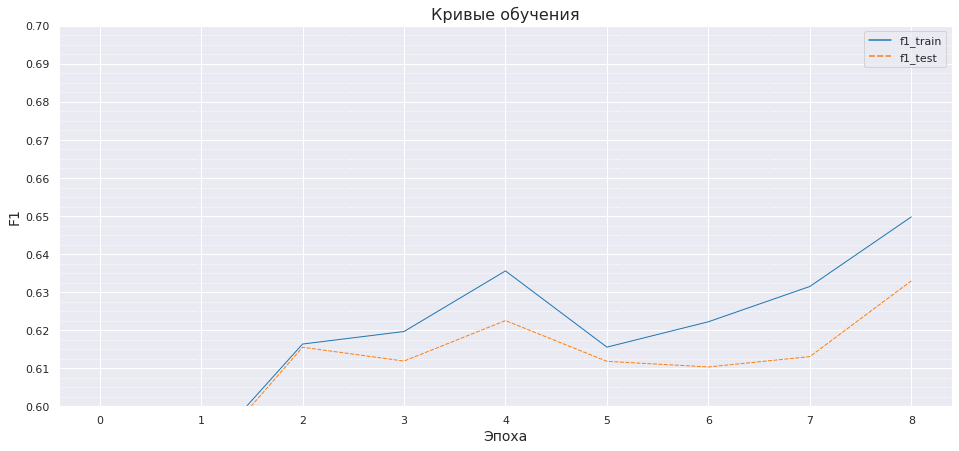

In [158]:
net_f1_stat_df = pd.DataFrame(test_stat[:, 1:3].detach().numpy(),
                              columns=['f1_train', 'f1_test']
                             )
learning_curve(net_f1_stat_df, [.6, .7])

In [159]:
MyNet_best.eval()
with torch.no_grad():
    net_test_probes = MyNet_best.forward(X_tst).flatten().detach().numpy()
    net_test_preds = np.rint(net_test_probes)

In [160]:
net_best_TESTmetrics = pd.DataFrame(
    data=[[f1_score(trgt_test.values, net_test_preds),
          accuracy_score(trgt_test.values, net_test_preds),
          precision_score(trgt_test.values, net_test_preds),
          recall_score(trgt_test.values, net_test_preds),
          roc_auc_score(trgt_test.values, net_test_probes)]],
    columns=['F1', 'Accuracy', 'Precision', 'Recall', 'AUC'],
    index=['MyNet_best_test']
)
net_best_TESTmetrics

,F1,Accuracy,Precision,Recall,AUC
MyNet_best_test,0.6287,0.6465,0.6772,0.5867,0.7054


Нейронная сеть протестирована на данных, обработанных классами `OneHotEncoder()` и `StandardScaler()`.

- Конфигурация сети (слой:число нейронов):     `1 :105`, `2 :64`, `3 :65`, `4 :32`, `5 :32`, `6 :16`, `7 :1`
- Выбраны параметры DropOut (слой:коэффициент):  `2 :.2`, `3:.2`, `4:.1`, `5 :.1`, `6 :0`
- Выбраны отимальный размер батча и темп обучения.

Собираем всю статистику вместе

In [161]:
all_stat = pd.concat([CBC_best_TESTmetrics_all_cat,
                      LGB_best_TESTmetrics,
                      net_best_TESTmetrics]
                    ).sort_values(by='F1', ascending=False)
display(all_stat)

,F1,Accuracy,Precision,Recall,AUC
MyNet_best_test,0.6287,0.6465,0.6772,0.5867,0.7054
CatBoost_base_test,0.6231,0.6509,0.6934,0.5657,0.7084
LightGBM_base_test,0.6190,0.6434,0.6801,0.5679,0.7040


**Вывод:** Лучшая модель по метрике `F1` - нейронная сеть.

<div class="alert alert-success">
<b>👍 Успех:</b> Лучшая модель выбрана!
</div>

**Матрица ошибок, ROC-кривая лучшей модели**

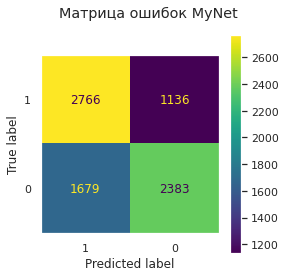

In [162]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(trgt_test, net_test_preds),
    display_labels=[1, 0]
)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
fig.suptitle('Матрица ошибок MyNet')
ax.grid()
plt.show()

Построим `ROC кривую` для модели `MyNet`

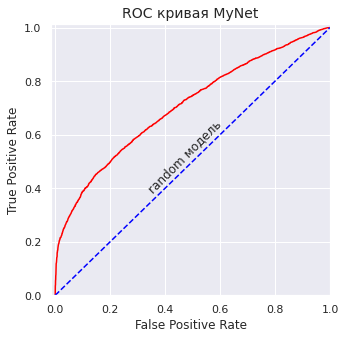

In [163]:
fpr, tpr, thresholds = roc_curve(trgt_test, net_test_probes)

fig, ax = plt.subplots(figsize=(5,5))

sns.lineplot(x=fpr[::3], y=tpr[::3], color='red')
sns.lineplot(x=[0, 1], y=[0, 1], color='blue', linestyle='--')

ax.text(0.47, 0.52, "random модель", rotation=45, size=12, ha="center", va="center")
ax.set_xlim([-0.015, 1])
ax.set_ylim([0, 1.015])
ax.set_title('ROC кривая MyNet', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)

plt.show()

## Проведите анализ важности факторов ДТП

Выведем важность признаков, базируясь на данных второй по рейтингу модели `CatBoostClassifier`

In [164]:
def plot_feature_importance(importance, fch_names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(fch_names)
    
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fch_df = pd.DataFrame(data)   
    fch_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(7, 7))
    sns.barplot(x=fch_df['feature_importance'], y=fch_df['feature_names'])
    
    plt.title(model_type + ' Feature importance', fontsize=14)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

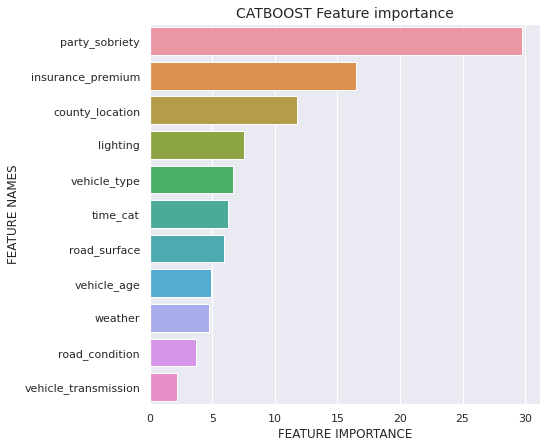

In [165]:
sns.set_theme(style='darkgrid')
plot_feature_importance(CBCModel_best.get_feature_importance(), fch_train_all_cat.columns,'CATBOOST')

1. Самым важным фактором прогноза виновности в ДТП является трезвость участника `party_sobriety`
2. Вторым по важности факторов является размер страховой премии `insurance_premium`
3. Третьим - локация `country_location`

Если говорить о мерах, которые можно предпринять для более точного прогнозирования виновника ДТП, то следовало бы выяснять условия страховки (например, размер франшизы) при заключении договора с клиентом каршеринга, проводить актуализацию этих данных через взаимодействие со страхововй компанией, добавить данные по стажу водителя, статистику предыдущих ДТП.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно! Важность признаков проанализирована!
</div>

## Выводы

1. Лучшей моделью, способной сделать прогноз по отобранным признакам и по метрике `F1` оказалась нейронная сеть.
2. Создать более совершенную модель прогнозирования виновности водителя при ДТП возможно, для этого надо добавить  еще 2-3 сильных признака. Например: данные по стажу водителя, коэффициент "бонус-малус", размер франшизы. Вероятно, эти признаки помогли бы прогнозировать виновность водителя еще более точно.

<div class="alert alert-success">
<b>👍 Успех:</b> Отличная работа! Было очень приятно проверять твой проект!

Оставлю хороший учебник по ML:
+  https://academy.yandex.ru/handbook/ml

Немного новостей с мира DL(вдруг заинтересует):
+  https://habr.com/ru/company/ods/blog/686962/

Вот тут проходят всякие соревнования, можешь себя попробовать:
+  https://hacks-ai.ru/


Возможно, что нибудь пригодится:
+  https://arxiv.org/ftp/arxiv/papers/2201/2201.00650.pdf
+  https://github.com/slgero/testovoe


Курс от МФТИ математика для DS:

+  https://www.youtube.com/watch?v=xccjt6lOoow&list=PLk4h7dmY2eYHHTyfLyrl7HmP-H3mMAW08&index=1


Тут много соревнований/лекций:

+  https://ods.ai/

stepic NLP/CV:

+  https://stepik.org/course/54098/syllabus
+  https://stepik.org/course/50352/syllabus

Еще есть от ВШЭ:

+  https://www.youtube.com/watch?v=mwjQaNt8qxk&list=PLEwK9wdS5g0og-DcF1apxutSM0GDLHz_3&ab_channel=%D0%A4%D0%9A%D0%9D%D0%92%D0%A8%D0%AD%E2%80%94%D0%B4%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F
+  https://github.com/hse-ds/iad-deep-learning

Удачи в следующих проектах!!!
</div>
